In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 5

***
## load and prepare data

In [4]:
!ls ../data/processed/dsv02

dataset-metadata.json  test.parquet  train.parquet


In [5]:
train = pd.read_parquet("../data/processed/dsv02/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
categ_feats = [
    'B_30_first', 'B_38_first', 'D_114_first', 'D_116_first', 'D_117_first', 
    'D_120_first', 'D_126_first', 'D_63_first', 'D_64_first', 'D_66_first', 'D_68_first',
    'B_30_last', 'B_38_last', 'D_114_last', 'D_116_last', 'D_117_last', 
    'D_120_last', 'D_126_last', 'D_63_last', 'D_64_last', 'D_66_last', 'D_68_last',
]
len(input_feats)

1562

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
train = train.reset_index()

del train_labels
gc.collect()

102

***
## model training

train with repeated cross validation

In [8]:
model_params = {
    'objective': 'binary',
    'metric': 'None',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_bin': 511,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 0.95,
    'feature_fraction': 0.15,
    'lambda_l1': 10.352308845012756,
    'lambda_l2': 1.569788743184169,
    'min_data_in_leaf': 2000,
    'path_smooth': 30.4965047619009,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': False,
    'verbosity': -1,
}

In [9]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold")
        valid_df = dataframe.query("fold == @fold")
        
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            categorical_feature=categ_feats,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            categorical_feature=categ_feats,
            free_raw_data=True,
        )
        
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            num_boost_round=1500,
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
            
        models.append(model)
        del train_dset,valid_dset
        gc.collect()
    
    return models,oof

In [10]:
# implement repeated cross validation
glob("../data/processed/cv*.parquet")

['../data/processed/cv1.parquet',
 '../data/processed/cv2.parquet',
 '../data/processed/cv4.parquet',
 '../data/processed/cv0.parquet',
 '../data/processed/cv3.parquet']

############################### repeated cross-validation step: 1/5 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.766686	valid_0's recall_at4: 0.624295	valid_0's norm_gini: 0.909076


[100]	valid_0's amex_metric: 0.779945	valid_0's recall_at4: 0.643693	valid_0's norm_gini: 0.916198


[150]	valid_0's amex_metric: 0.786883	valid_0's recall_at4: 0.653875	valid_0's norm_gini: 0.919891


[200]	valid_0's amex_metric: 0.790396	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.921783


[250]	valid_0's amex_metric: 0.792123	valid_0's recall_at4: 0.661323	valid_0's norm_gini: 0.922923


[300]	valid_0's amex_metric: 0.793983	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.923613


[350]	valid_0's amex_metric: 0.79508	valid_0's recall_at4: 0.666078	valid_0's norm_gini: 0.924083


[400]	valid_0's amex_metric: 0.7959	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.924502


[450]	valid_0's amex_metric: 0.796823	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.924749


[500]	valid_0's amex_metric: 0.797233	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.924981


[550]	valid_0's amex_metric: 0.797466	valid_0's recall_at4: 0.66978	valid_0's norm_gini: 0.925151


[600]	valid_0's amex_metric: 0.797365	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.925286


[650]	valid_0's amex_metric: 0.797426	valid_0's recall_at4: 0.669528	valid_0's norm_gini: 0.925324


[700]	valid_0's amex_metric: 0.798015	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.925366


[750]	valid_0's amex_metric: 0.797187	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.925392


[800]	valid_0's amex_metric: 0.797711	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925389


[850]	valid_0's amex_metric: 0.797015	valid_0's recall_at4: 0.668602	valid_0's norm_gini: 0.925427


[900]	valid_0's amex_metric: 0.796899	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925448


[950]	valid_0's amex_metric: 0.797278	valid_0's recall_at4: 0.669107	valid_0's norm_gini: 0.925448


[1000]	valid_0's amex_metric: 0.798056	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.925447


[1050]	valid_0's amex_metric: 0.798543	valid_0's recall_at4: 0.67159	valid_0's norm_gini: 0.925495


[1100]	valid_0's amex_metric: 0.798185	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925496


[1150]	valid_0's amex_metric: 0.798146	valid_0's recall_at4: 0.67079	valid_0's norm_gini: 0.925502


[1200]	valid_0's amex_metric: 0.797872	valid_0's recall_at4: 0.670243	valid_0's norm_gini: 0.925501


[1250]	valid_0's amex_metric: 0.798172	valid_0's recall_at4: 0.670832	valid_0's norm_gini: 0.925511


[1300]	valid_0's amex_metric: 0.797488	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.925491


[1350]	valid_0's amex_metric: 0.797309	valid_0's recall_at4: 0.669149	valid_0's norm_gini: 0.925468


[1400]	valid_0's amex_metric: 0.797306	valid_0's recall_at4: 0.669149	valid_0's norm_gini: 0.925464


[1450]	valid_0's amex_metric: 0.79719	valid_0's recall_at4: 0.668939	valid_0's norm_gini: 0.92544


[1500]	valid_0's amex_metric: 0.796925	valid_0's recall_at4: 0.668434	valid_0's norm_gini: 0.925416


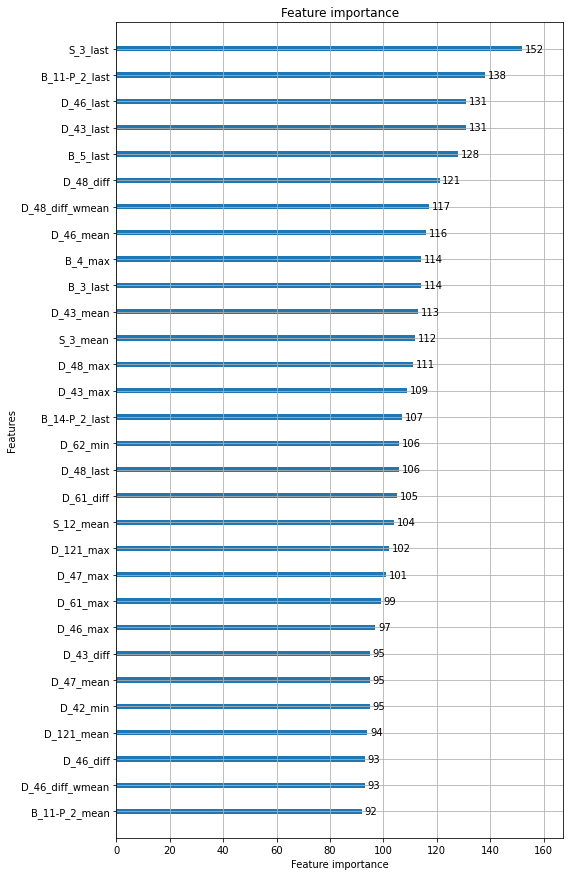

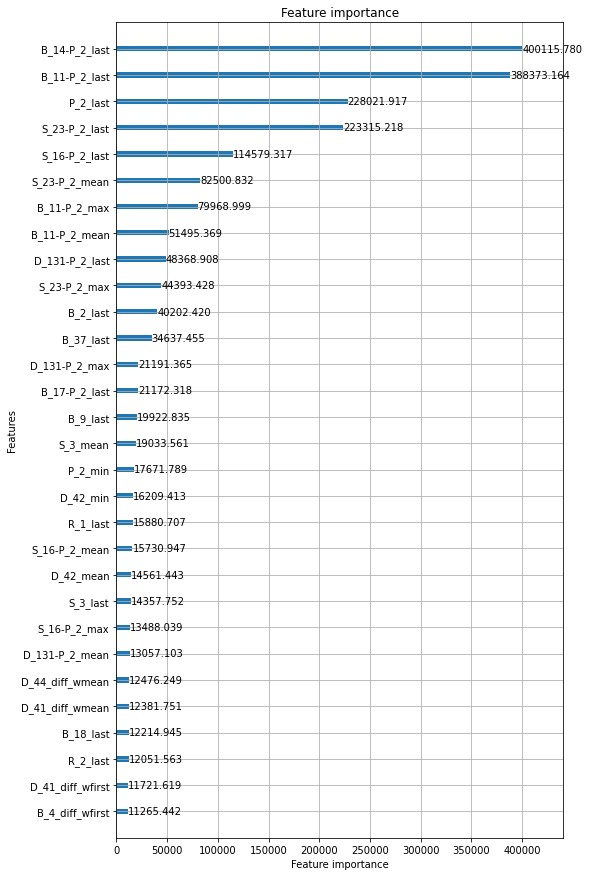

######################################## training model 2/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.765344	valid_0's recall_at4: 0.622823	valid_0's norm_gini: 0.907865


[100]	valid_0's amex_metric: 0.775995	valid_0's recall_at4: 0.637002	valid_0's norm_gini: 0.914988


[150]	valid_0's amex_metric: 0.782943	valid_0's recall_at4: 0.647185	valid_0's norm_gini: 0.918702


[200]	valid_0's amex_metric: 0.787897	valid_0's recall_at4: 0.655053	valid_0's norm_gini: 0.920741


[250]	valid_0's amex_metric: 0.790531	valid_0's recall_at4: 0.659177	valid_0's norm_gini: 0.921886


[300]	valid_0's amex_metric: 0.791274	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.922613


[350]	valid_0's amex_metric: 0.79269	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.923132


[400]	valid_0's amex_metric: 0.793514	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.923517


[450]	valid_0's amex_metric: 0.794388	valid_0's recall_at4: 0.664941	valid_0's norm_gini: 0.923835


[500]	valid_0's amex_metric: 0.794761	valid_0's recall_at4: 0.665489	valid_0's norm_gini: 0.924033


[550]	valid_0's amex_metric: 0.794405	valid_0's recall_at4: 0.664605	valid_0's norm_gini: 0.924206


[600]	valid_0's amex_metric: 0.79518	valid_0's recall_at4: 0.665993	valid_0's norm_gini: 0.924367


[650]	valid_0's amex_metric: 0.79534	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.924476


[700]	valid_0's amex_metric: 0.79554	valid_0's recall_at4: 0.66654	valid_0's norm_gini: 0.92454


[750]	valid_0's amex_metric: 0.795437	valid_0's recall_at4: 0.666246	valid_0's norm_gini: 0.924629


[800]	valid_0's amex_metric: 0.795523	valid_0's recall_at4: 0.666372	valid_0's norm_gini: 0.924674


[850]	valid_0's amex_metric: 0.79547	valid_0's recall_at4: 0.666246	valid_0's norm_gini: 0.924695


[900]	valid_0's amex_metric: 0.795971	valid_0's recall_at4: 0.667214	valid_0's norm_gini: 0.924728


[950]	valid_0's amex_metric: 0.795802	valid_0's recall_at4: 0.666793	valid_0's norm_gini: 0.924811


[1000]	valid_0's amex_metric: 0.795643	valid_0's recall_at4: 0.666414	valid_0's norm_gini: 0.924871


[1050]	valid_0's amex_metric: 0.795953	valid_0's recall_at4: 0.667003	valid_0's norm_gini: 0.924902


[1100]	valid_0's amex_metric: 0.796674	valid_0's recall_at4: 0.668434	valid_0's norm_gini: 0.924915


[1150]	valid_0's amex_metric: 0.796616	valid_0's recall_at4: 0.668308	valid_0's norm_gini: 0.924924


[1200]	valid_0's amex_metric: 0.796143	valid_0's recall_at4: 0.66734	valid_0's norm_gini: 0.924946


[1250]	valid_0's amex_metric: 0.795709	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.924961


[1300]	valid_0's amex_metric: 0.795736	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.924973


[1350]	valid_0's amex_metric: 0.795827	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924987


[1400]	valid_0's amex_metric: 0.795438	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.924966


[1450]	valid_0's amex_metric: 0.795386	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924946


[1500]	valid_0's amex_metric: 0.795084	valid_0's recall_at4: 0.665236	valid_0's norm_gini: 0.924932


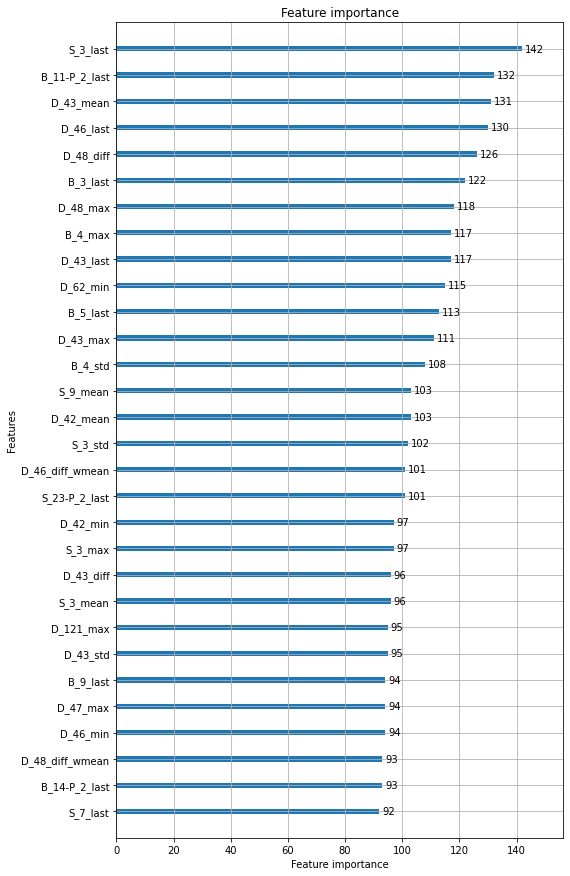

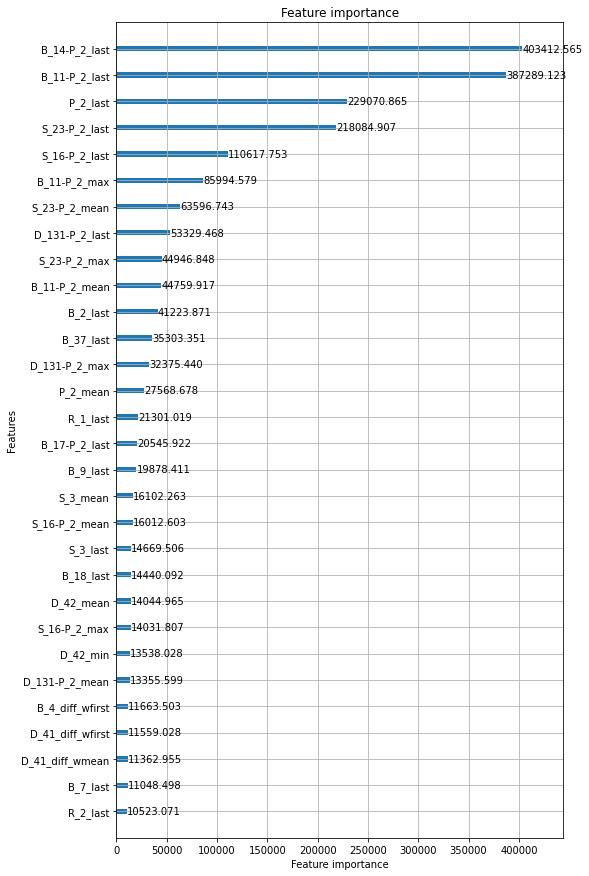

######################################## training model 3/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.760896	valid_0's recall_at4: 0.614533	valid_0's norm_gini: 0.907259


[100]	valid_0's amex_metric: 0.771247	valid_0's recall_at4: 0.628419	valid_0's norm_gini: 0.914076


[150]	valid_0's amex_metric: 0.77878	valid_0's recall_at4: 0.63999	valid_0's norm_gini: 0.917571


[200]	valid_0's amex_metric: 0.782038	valid_0's recall_at4: 0.644576	valid_0's norm_gini: 0.9195


[250]	valid_0's amex_metric: 0.784659	valid_0's recall_at4: 0.648784	valid_0's norm_gini: 0.920534


[300]	valid_0's amex_metric: 0.786287	valid_0's recall_at4: 0.651309	valid_0's norm_gini: 0.921264


[350]	valid_0's amex_metric: 0.787561	valid_0's recall_at4: 0.65337	valid_0's norm_gini: 0.921752


[400]	valid_0's amex_metric: 0.788335	valid_0's recall_at4: 0.654549	valid_0's norm_gini: 0.922121


[450]	valid_0's amex_metric: 0.78896	valid_0's recall_at4: 0.655474	valid_0's norm_gini: 0.922446


[500]	valid_0's amex_metric: 0.790005	valid_0's recall_at4: 0.657368	valid_0's norm_gini: 0.922642


[550]	valid_0's amex_metric: 0.78991	valid_0's recall_at4: 0.657031	valid_0's norm_gini: 0.922789


[600]	valid_0's amex_metric: 0.790832	valid_0's recall_at4: 0.658798	valid_0's norm_gini: 0.922866


[650]	valid_0's amex_metric: 0.790569	valid_0's recall_at4: 0.658125	valid_0's norm_gini: 0.923013


[700]	valid_0's amex_metric: 0.790518	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.923122


[750]	valid_0's amex_metric: 0.790324	valid_0's recall_at4: 0.657452	valid_0's norm_gini: 0.923197


[800]	valid_0's amex_metric: 0.790671	valid_0's recall_at4: 0.658125	valid_0's norm_gini: 0.923217


[850]	valid_0's amex_metric: 0.791071	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.923259


[900]	valid_0's amex_metric: 0.790845	valid_0's recall_at4: 0.65842	valid_0's norm_gini: 0.92327


[950]	valid_0's amex_metric: 0.791033	valid_0's recall_at4: 0.658798	valid_0's norm_gini: 0.923267


[1000]	valid_0's amex_metric: 0.790894	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.923284


[1050]	valid_0's amex_metric: 0.790682	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.923323


[1100]	valid_0's amex_metric: 0.790709	valid_0's recall_at4: 0.658083	valid_0's norm_gini: 0.923335


[1150]	valid_0's amex_metric: 0.790586	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.923383


[1200]	valid_0's amex_metric: 0.790699	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.923357


[1250]	valid_0's amex_metric: 0.790515	valid_0's recall_at4: 0.657662	valid_0's norm_gini: 0.923367


[1300]	valid_0's amex_metric: 0.790759	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.92335


[1350]	valid_0's amex_metric: 0.790258	valid_0's recall_at4: 0.657157	valid_0's norm_gini: 0.923358


[1400]	valid_0's amex_metric: 0.790101	valid_0's recall_at4: 0.656863	valid_0's norm_gini: 0.92334


[1450]	valid_0's amex_metric: 0.789588	valid_0's recall_at4: 0.655853	valid_0's norm_gini: 0.923324


[1500]	valid_0's amex_metric: 0.790195	valid_0's recall_at4: 0.657073	valid_0's norm_gini: 0.923317


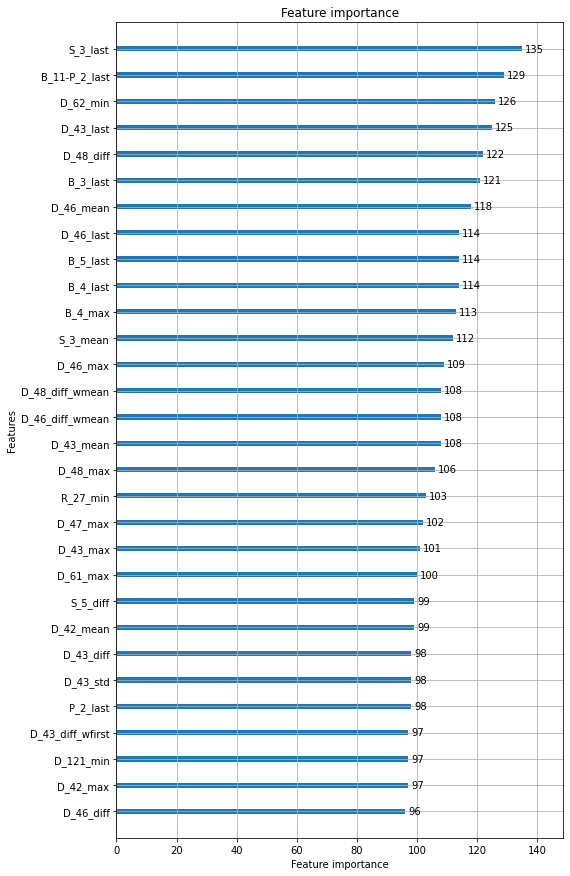

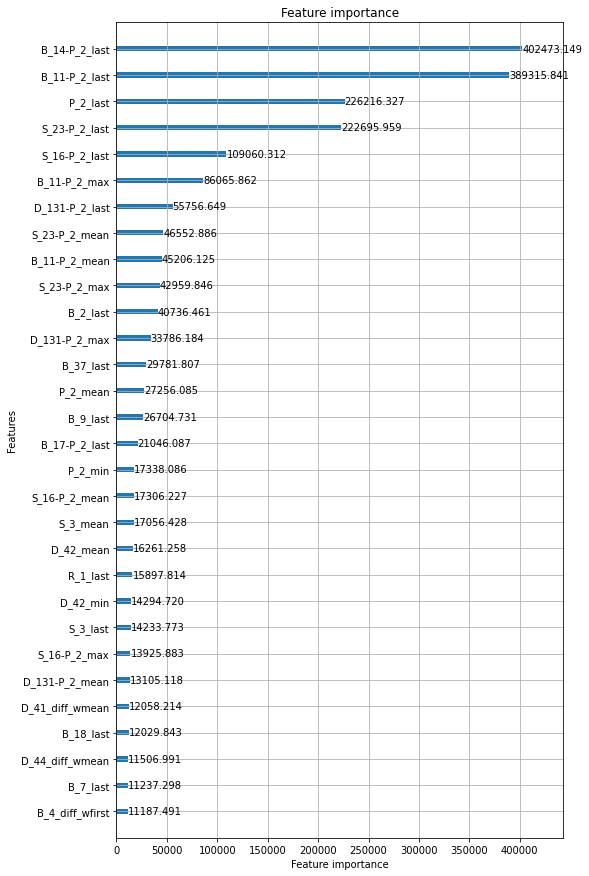

######################################## training model 4/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.761026	valid_0's recall_at4: 0.615275	valid_0's norm_gini: 0.906776


[100]	valid_0's amex_metric: 0.771884	valid_0's recall_at4: 0.630086	valid_0's norm_gini: 0.913681


[150]	valid_0's amex_metric: 0.778124	valid_0's recall_at4: 0.638797	valid_0's norm_gini: 0.917451


[200]	valid_0's amex_metric: 0.781818	valid_0's recall_at4: 0.644141	valid_0's norm_gini: 0.919496


[250]	valid_0's amex_metric: 0.784947	valid_0's recall_at4: 0.64919	valid_0's norm_gini: 0.920705


[300]	valid_0's amex_metric: 0.785774	valid_0's recall_at4: 0.649947	valid_0's norm_gini: 0.921601


[350]	valid_0's amex_metric: 0.787105	valid_0's recall_at4: 0.652051	valid_0's norm_gini: 0.922159


[400]	valid_0's amex_metric: 0.787614	valid_0's recall_at4: 0.652556	valid_0's norm_gini: 0.922672


[450]	valid_0's amex_metric: 0.78771	valid_0's recall_at4: 0.652472	valid_0's norm_gini: 0.922948


[500]	valid_0's amex_metric: 0.788039	valid_0's recall_at4: 0.652893	valid_0's norm_gini: 0.923186


[550]	valid_0's amex_metric: 0.787831	valid_0's recall_at4: 0.652304	valid_0's norm_gini: 0.923359


[600]	valid_0's amex_metric: 0.788106	valid_0's recall_at4: 0.652725	valid_0's norm_gini: 0.923488


[650]	valid_0's amex_metric: 0.788299	valid_0's recall_at4: 0.653019	valid_0's norm_gini: 0.923578


[700]	valid_0's amex_metric: 0.788651	valid_0's recall_at4: 0.653608	valid_0's norm_gini: 0.923694


[750]	valid_0's amex_metric: 0.788521	valid_0's recall_at4: 0.653272	valid_0's norm_gini: 0.923771


[800]	valid_0's amex_metric: 0.78871	valid_0's recall_at4: 0.653566	valid_0's norm_gini: 0.923854


[850]	valid_0's amex_metric: 0.789292	valid_0's recall_at4: 0.654702	valid_0's norm_gini: 0.923882


[900]	valid_0's amex_metric: 0.789634	valid_0's recall_at4: 0.655333	valid_0's norm_gini: 0.923935


[950]	valid_0's amex_metric: 0.7892	valid_0's recall_at4: 0.65445	valid_0's norm_gini: 0.92395


[1000]	valid_0's amex_metric: 0.789415	valid_0's recall_at4: 0.654829	valid_0's norm_gini: 0.924001


[1050]	valid_0's amex_metric: 0.790225	valid_0's recall_at4: 0.656385	valid_0's norm_gini: 0.924064


[1100]	valid_0's amex_metric: 0.790477	valid_0's recall_at4: 0.656848	valid_0's norm_gini: 0.924106


[1150]	valid_0's amex_metric: 0.789569	valid_0's recall_at4: 0.654997	valid_0's norm_gini: 0.924141


[1200]	valid_0's amex_metric: 0.789378	valid_0's recall_at4: 0.654618	valid_0's norm_gini: 0.924138


[1250]	valid_0's amex_metric: 0.789685	valid_0's recall_at4: 0.655207	valid_0's norm_gini: 0.924162


[1300]	valid_0's amex_metric: 0.789714	valid_0's recall_at4: 0.655249	valid_0's norm_gini: 0.924179


[1350]	valid_0's amex_metric: 0.789768	valid_0's recall_at4: 0.655333	valid_0's norm_gini: 0.924202


[1400]	valid_0's amex_metric: 0.789856	valid_0's recall_at4: 0.655502	valid_0's norm_gini: 0.924209


[1450]	valid_0's amex_metric: 0.789699	valid_0's recall_at4: 0.655207	valid_0's norm_gini: 0.924191


[1500]	valid_0's amex_metric: 0.790255	valid_0's recall_at4: 0.656343	valid_0's norm_gini: 0.924167


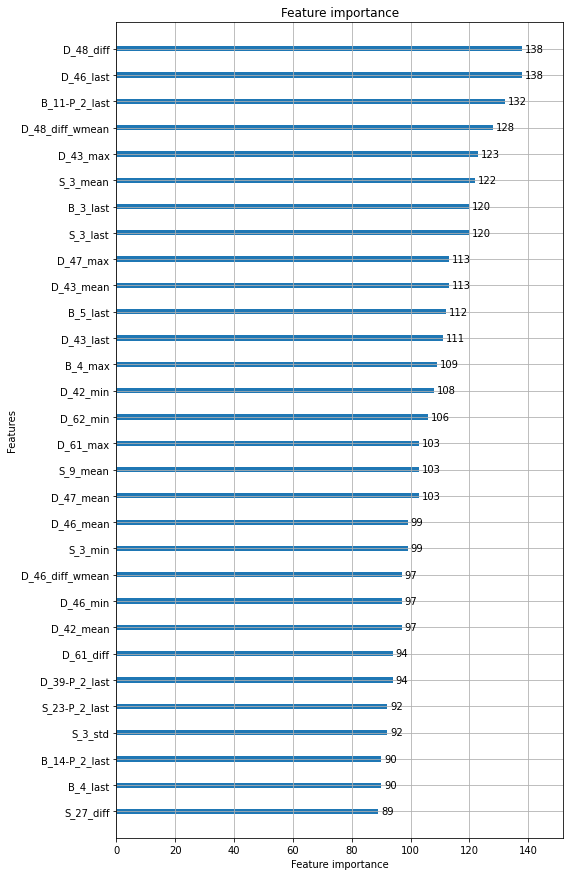

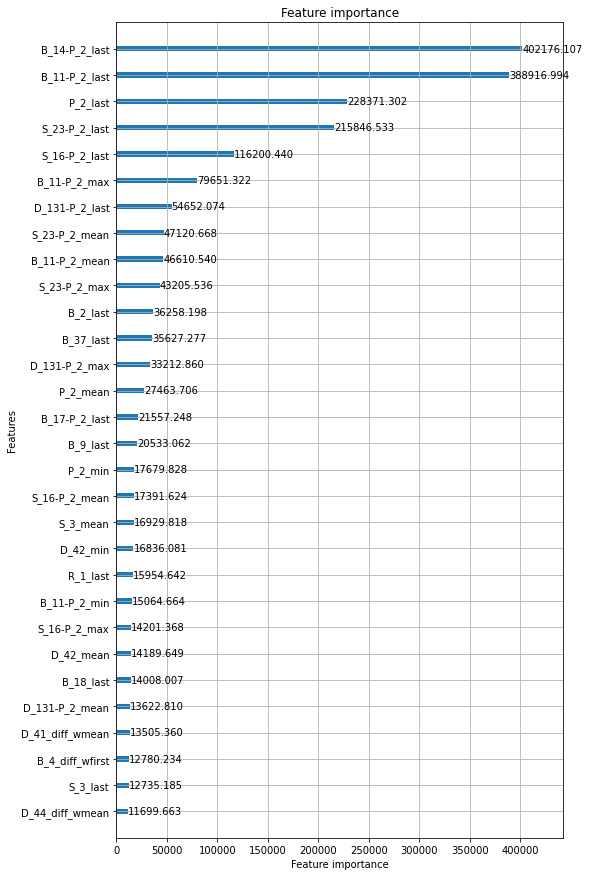

######################################## training model 5/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.769101	valid_0's recall_at4: 0.62794	valid_0's norm_gini: 0.910262


[100]	valid_0's amex_metric: 0.781085	valid_0's recall_at4: 0.645024	valid_0's norm_gini: 0.917147


[150]	valid_0's amex_metric: 0.788172	valid_0's recall_at4: 0.655544	valid_0's norm_gini: 0.9208


[200]	valid_0's amex_metric: 0.790416	valid_0's recall_at4: 0.658069	valid_0's norm_gini: 0.922764


[250]	valid_0's amex_metric: 0.792856	valid_0's recall_at4: 0.661772	valid_0's norm_gini: 0.92394


[300]	valid_0's amex_metric: 0.794716	valid_0's recall_at4: 0.664843	valid_0's norm_gini: 0.924588


[350]	valid_0's amex_metric: 0.796052	valid_0's recall_at4: 0.667031	valid_0's norm_gini: 0.925072


[400]	valid_0's amex_metric: 0.796904	valid_0's recall_at4: 0.66842	valid_0's norm_gini: 0.925388


[450]	valid_0's amex_metric: 0.797748	valid_0's recall_at4: 0.669851	valid_0's norm_gini: 0.925646


[500]	valid_0's amex_metric: 0.797994	valid_0's recall_at4: 0.670145	valid_0's norm_gini: 0.925844


[550]	valid_0's amex_metric: 0.797925	valid_0's recall_at4: 0.669851	valid_0's norm_gini: 0.926


[600]	valid_0's amex_metric: 0.798626	valid_0's recall_at4: 0.671155	valid_0's norm_gini: 0.926097


[650]	valid_0's amex_metric: 0.798914	valid_0's recall_at4: 0.671618	valid_0's norm_gini: 0.926211


[700]	valid_0's amex_metric: 0.798833	valid_0's recall_at4: 0.671365	valid_0's norm_gini: 0.9263


[750]	valid_0's amex_metric: 0.79926	valid_0's recall_at4: 0.672123	valid_0's norm_gini: 0.926397


[800]	valid_0's amex_metric: 0.79944	valid_0's recall_at4: 0.672417	valid_0's norm_gini: 0.926463


[850]	valid_0's amex_metric: 0.799532	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.926478


[900]	valid_0's amex_metric: 0.799846	valid_0's recall_at4: 0.673175	valid_0's norm_gini: 0.926517


[950]	valid_0's amex_metric: 0.799838	valid_0's recall_at4: 0.673133	valid_0's norm_gini: 0.926543


[1000]	valid_0's amex_metric: 0.799834	valid_0's recall_at4: 0.673133	valid_0's norm_gini: 0.926535


[1050]	valid_0's amex_metric: 0.799506	valid_0's recall_at4: 0.672502	valid_0's norm_gini: 0.926511


[1100]	valid_0's amex_metric: 0.799764	valid_0's recall_at4: 0.673007	valid_0's norm_gini: 0.926522


[1150]	valid_0's amex_metric: 0.800059	valid_0's recall_at4: 0.673596	valid_0's norm_gini: 0.926523


[1200]	valid_0's amex_metric: 0.799567	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.926549


[1250]	valid_0's amex_metric: 0.799817	valid_0's recall_at4: 0.673091	valid_0's norm_gini: 0.926544


[1300]	valid_0's amex_metric: 0.800221	valid_0's recall_at4: 0.67389	valid_0's norm_gini: 0.926551


[1350]	valid_0's amex_metric: 0.799876	valid_0's recall_at4: 0.673217	valid_0's norm_gini: 0.926534


[1400]	valid_0's amex_metric: 0.799579	valid_0's recall_at4: 0.672628	valid_0's norm_gini: 0.92653


[1450]	valid_0's amex_metric: 0.799514	valid_0's recall_at4: 0.672502	valid_0's norm_gini: 0.926527


[1500]	valid_0's amex_metric: 0.799463	valid_0's recall_at4: 0.672417	valid_0's norm_gini: 0.926509


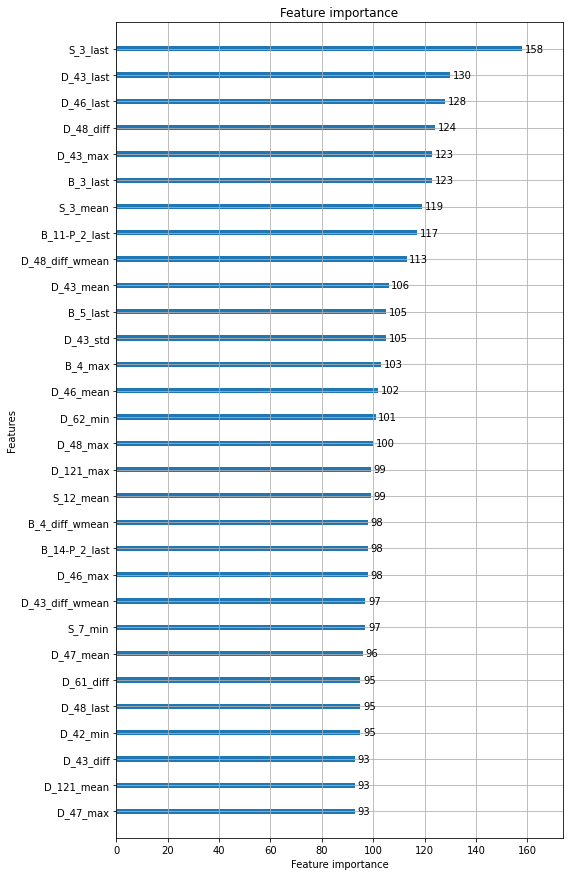

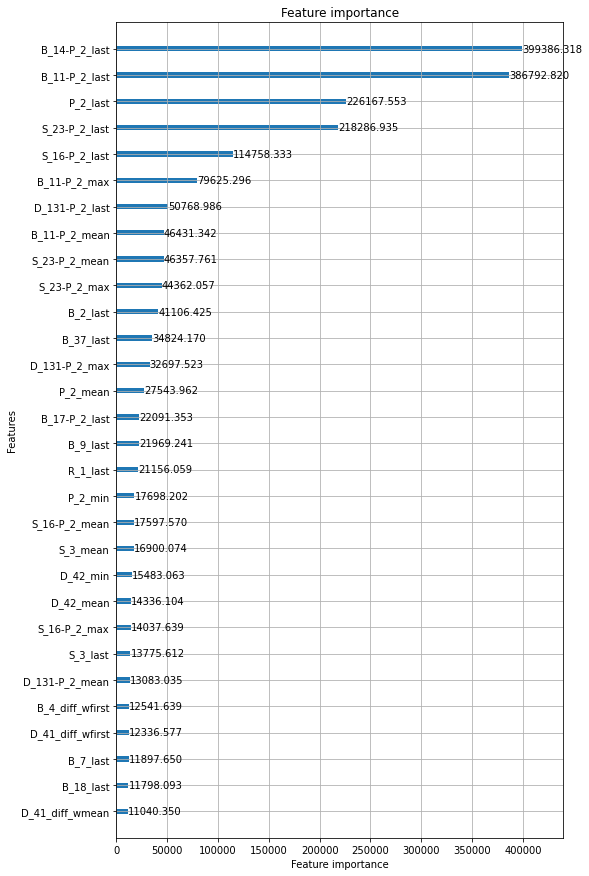

Training time: 27.68463659286499 min.
OOF recall_at4: 0.6638334399299828
OOF normalized_gini: 0.9244077244123212
OOF competition metric: 0.794120582171152


############################### repeated cross-validation step: 2/5 ################################


######################################## training model 1/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.765948	valid_0's recall_at4: 0.623201	valid_0's norm_gini: 0.908694


[100]	valid_0's amex_metric: 0.778481	valid_0's recall_at4: 0.64121	valid_0's norm_gini: 0.915752


[150]	valid_0's amex_metric: 0.785846	valid_0's recall_at4: 0.65215	valid_0's norm_gini: 0.919542


[200]	valid_0's amex_metric: 0.791022	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.921604


[250]	valid_0's amex_metric: 0.792317	valid_0's recall_at4: 0.66187	valid_0's norm_gini: 0.922763


[300]	valid_0's amex_metric: 0.793981	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.923525


[350]	valid_0's amex_metric: 0.794433	valid_0's recall_at4: 0.664857	valid_0's norm_gini: 0.92401


[400]	valid_0's amex_metric: 0.794883	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.924362


[450]	valid_0's amex_metric: 0.795217	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.924652


[500]	valid_0's amex_metric: 0.795756	valid_0's recall_at4: 0.666625	valid_0's norm_gini: 0.924888


[550]	valid_0's amex_metric: 0.796158	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.925018


[600]	valid_0's amex_metric: 0.796073	valid_0's recall_at4: 0.666961	valid_0's norm_gini: 0.925185


[650]	valid_0's amex_metric: 0.796281	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.925264


[700]	valid_0's amex_metric: 0.796376	valid_0's recall_at4: 0.667382	valid_0's norm_gini: 0.92537


[750]	valid_0's amex_metric: 0.796529	valid_0's recall_at4: 0.667634	valid_0's norm_gini: 0.925423


[800]	valid_0's amex_metric: 0.797098	valid_0's recall_at4: 0.668728	valid_0's norm_gini: 0.925468


[850]	valid_0's amex_metric: 0.796936	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925522


[900]	valid_0's amex_metric: 0.79673	valid_0's recall_at4: 0.667929	valid_0's norm_gini: 0.925532


[950]	valid_0's amex_metric: 0.796923	valid_0's recall_at4: 0.668266	valid_0's norm_gini: 0.925581


[1000]	valid_0's amex_metric: 0.797081	valid_0's recall_at4: 0.66856	valid_0's norm_gini: 0.925603


[1050]	valid_0's amex_metric: 0.796697	valid_0's recall_at4: 0.667761	valid_0's norm_gini: 0.925634


[1100]	valid_0's amex_metric: 0.79714	valid_0's recall_at4: 0.668602	valid_0's norm_gini: 0.925678


[1150]	valid_0's amex_metric: 0.797	valid_0's recall_at4: 0.668308	valid_0's norm_gini: 0.925691


[1200]	valid_0's amex_metric: 0.796925	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.925711


[1250]	valid_0's amex_metric: 0.79787	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925707


[1300]	valid_0's amex_metric: 0.797602	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.925719


[1350]	valid_0's amex_metric: 0.798052	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.925735


[1400]	valid_0's amex_metric: 0.797362	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.925743


[1450]	valid_0's amex_metric: 0.79755	valid_0's recall_at4: 0.66936	valid_0's norm_gini: 0.925741


[1500]	valid_0's amex_metric: 0.797709	valid_0's recall_at4: 0.669654	valid_0's norm_gini: 0.925763


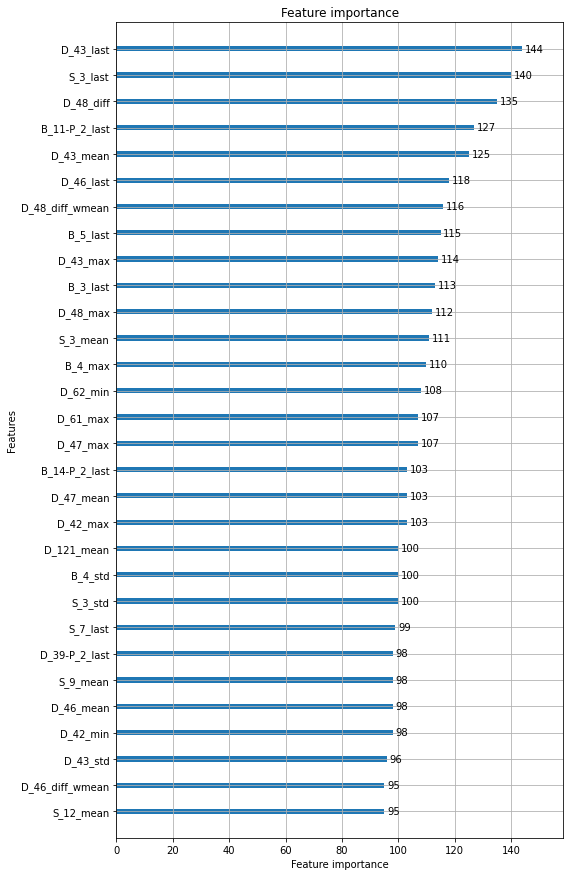

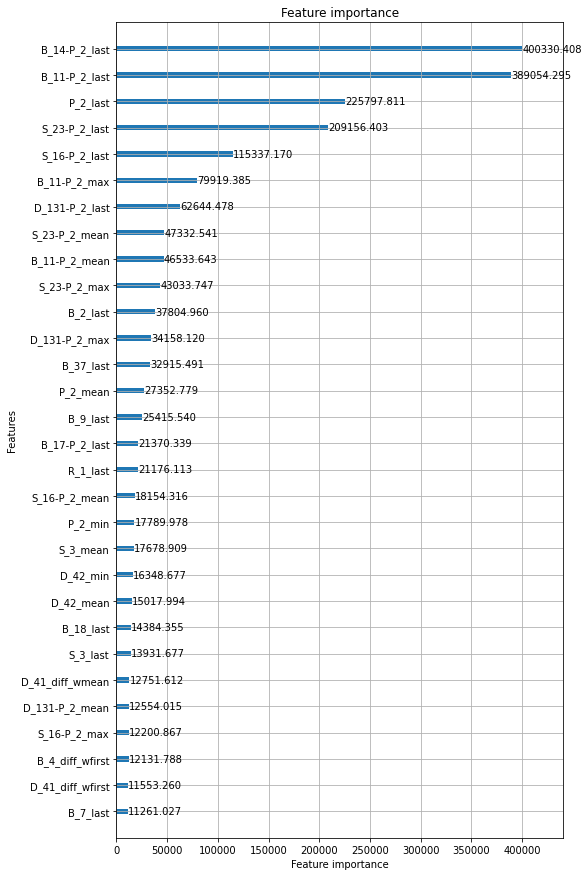

######################################## training model 2/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.761553	valid_0's recall_at4: 0.615333	valid_0's norm_gini: 0.907773


[100]	valid_0's amex_metric: 0.775232	valid_0's recall_at4: 0.63553	valid_0's norm_gini: 0.914934


[150]	valid_0's amex_metric: 0.781123	valid_0's recall_at4: 0.643735	valid_0's norm_gini: 0.918511


[200]	valid_0's amex_metric: 0.783311	valid_0's recall_at4: 0.646259	valid_0's norm_gini: 0.920363


[250]	valid_0's amex_metric: 0.785744	valid_0's recall_at4: 0.650004	valid_0's norm_gini: 0.921484


[300]	valid_0's amex_metric: 0.787077	valid_0's recall_at4: 0.65194	valid_0's norm_gini: 0.922215


[350]	valid_0's amex_metric: 0.788279	valid_0's recall_at4: 0.653833	valid_0's norm_gini: 0.922725


[400]	valid_0's amex_metric: 0.789149	valid_0's recall_at4: 0.655222	valid_0's norm_gini: 0.923077


[450]	valid_0's amex_metric: 0.788996	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.923317


[500]	valid_0's amex_metric: 0.788968	valid_0's recall_at4: 0.654422	valid_0's norm_gini: 0.923514


[550]	valid_0's amex_metric: 0.789284	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.923682


[600]	valid_0's amex_metric: 0.789057	valid_0's recall_at4: 0.654296	valid_0's norm_gini: 0.923818


[650]	valid_0's amex_metric: 0.789611	valid_0's recall_at4: 0.655306	valid_0's norm_gini: 0.923916


[700]	valid_0's amex_metric: 0.789912	valid_0's recall_at4: 0.655853	valid_0's norm_gini: 0.923972


[750]	valid_0's amex_metric: 0.790034	valid_0's recall_at4: 0.656021	valid_0's norm_gini: 0.924047


[800]	valid_0's amex_metric: 0.790634	valid_0's recall_at4: 0.657157	valid_0's norm_gini: 0.924111


[850]	valid_0's amex_metric: 0.790477	valid_0's recall_at4: 0.656821	valid_0's norm_gini: 0.924134


[900]	valid_0's amex_metric: 0.790661	valid_0's recall_at4: 0.657157	valid_0's norm_gini: 0.924165


[950]	valid_0's amex_metric: 0.790882	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.924186


[1000]	valid_0's amex_metric: 0.790286	valid_0's recall_at4: 0.656358	valid_0's norm_gini: 0.924215


[1050]	valid_0's amex_metric: 0.790447	valid_0's recall_at4: 0.656694	valid_0's norm_gini: 0.924199


[1100]	valid_0's amex_metric: 0.790137	valid_0's recall_at4: 0.656063	valid_0's norm_gini: 0.924212


[1150]	valid_0's amex_metric: 0.790587	valid_0's recall_at4: 0.656947	valid_0's norm_gini: 0.924226


[1200]	valid_0's amex_metric: 0.790859	valid_0's recall_at4: 0.657452	valid_0's norm_gini: 0.924266


[1250]	valid_0's amex_metric: 0.790925	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.924273


[1300]	valid_0's amex_metric: 0.791486	valid_0's recall_at4: 0.658714	valid_0's norm_gini: 0.924257


[1350]	valid_0's amex_metric: 0.791063	valid_0's recall_at4: 0.657873	valid_0's norm_gini: 0.924253


[1400]	valid_0's amex_metric: 0.79137	valid_0's recall_at4: 0.658462	valid_0's norm_gini: 0.924278


[1450]	valid_0's amex_metric: 0.790656	valid_0's recall_at4: 0.657073	valid_0's norm_gini: 0.92424


[1500]	valid_0's amex_metric: 0.7907	valid_0's recall_at4: 0.657157	valid_0's norm_gini: 0.924243


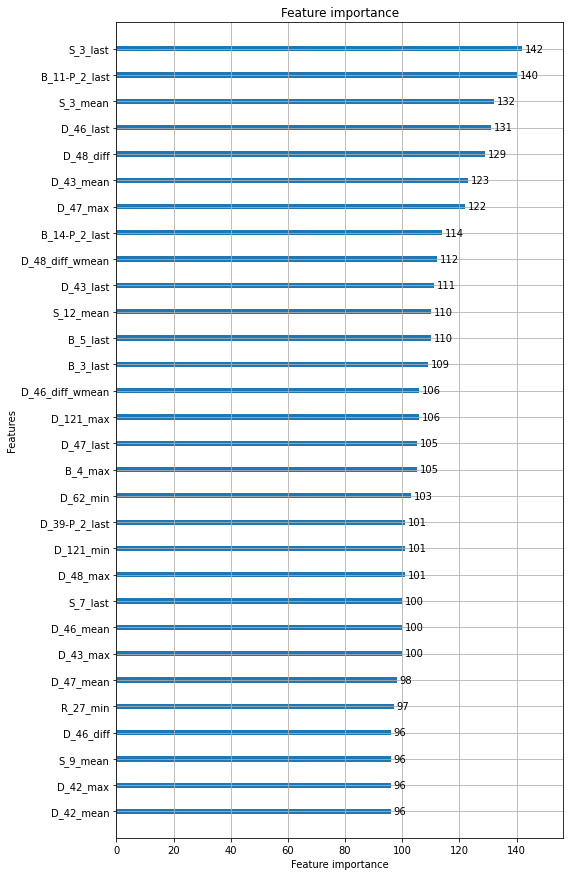

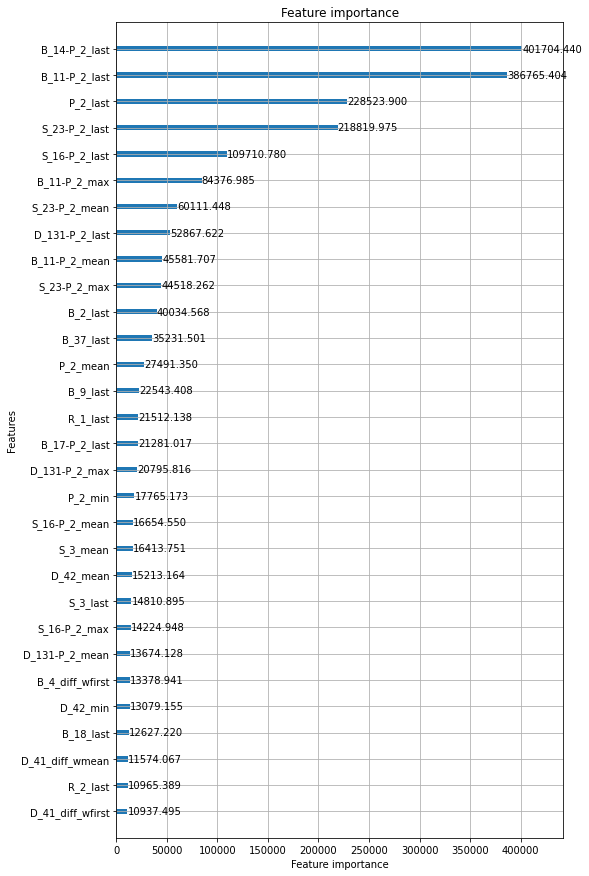

######################################## training model 3/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.760194	valid_0's recall_at4: 0.614028	valid_0's norm_gini: 0.906359


[100]	valid_0's amex_metric: 0.77136	valid_0's recall_at4: 0.629092	valid_0's norm_gini: 0.913629


[150]	valid_0's amex_metric: 0.777991	valid_0's recall_at4: 0.638517	valid_0's norm_gini: 0.917464


[200]	valid_0's amex_metric: 0.782074	valid_0's recall_at4: 0.644576	valid_0's norm_gini: 0.919571


[250]	valid_0's amex_metric: 0.785376	valid_0's recall_at4: 0.64992	valid_0's norm_gini: 0.920831


[300]	valid_0's amex_metric: 0.787363	valid_0's recall_at4: 0.653118	valid_0's norm_gini: 0.921609


[350]	valid_0's amex_metric: 0.787962	valid_0's recall_at4: 0.653749	valid_0's norm_gini: 0.922175


[400]	valid_0's amex_metric: 0.789991	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.922572


[450]	valid_0's amex_metric: 0.790525	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.922884


[500]	valid_0's amex_metric: 0.790706	valid_0's recall_at4: 0.658293	valid_0's norm_gini: 0.923118


[550]	valid_0's amex_metric: 0.790597	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.92328


[600]	valid_0's amex_metric: 0.790995	valid_0's recall_at4: 0.658588	valid_0's norm_gini: 0.923403


[650]	valid_0's amex_metric: 0.790759	valid_0's recall_at4: 0.657999	valid_0's norm_gini: 0.923519


[700]	valid_0's amex_metric: 0.79111	valid_0's recall_at4: 0.65863	valid_0's norm_gini: 0.923591


[750]	valid_0's amex_metric: 0.790894	valid_0's recall_at4: 0.658125	valid_0's norm_gini: 0.923663


[800]	valid_0's amex_metric: 0.790469	valid_0's recall_at4: 0.657199	valid_0's norm_gini: 0.923739


[850]	valid_0's amex_metric: 0.791463	valid_0's recall_at4: 0.659135	valid_0's norm_gini: 0.923792


[900]	valid_0's amex_metric: 0.791646	valid_0's recall_at4: 0.659472	valid_0's norm_gini: 0.923821


[950]	valid_0's amex_metric: 0.791904	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.923873


[1000]	valid_0's amex_metric: 0.79245	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.923914


[1050]	valid_0's amex_metric: 0.792079	valid_0's recall_at4: 0.660187	valid_0's norm_gini: 0.923972


[1100]	valid_0's amex_metric: 0.792048	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.923992


[1150]	valid_0's amex_metric: 0.791766	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.924019


[1200]	valid_0's amex_metric: 0.791754	valid_0's recall_at4: 0.659472	valid_0's norm_gini: 0.924036


[1250]	valid_0's amex_metric: 0.791589	valid_0's recall_at4: 0.659135	valid_0's norm_gini: 0.924042


[1300]	valid_0's amex_metric: 0.791972	valid_0's recall_at4: 0.659892	valid_0's norm_gini: 0.924053


[1350]	valid_0's amex_metric: 0.791916	valid_0's recall_at4: 0.659766	valid_0's norm_gini: 0.924065


[1400]	valid_0's amex_metric: 0.791141	valid_0's recall_at4: 0.658209	valid_0's norm_gini: 0.924073


[1450]	valid_0's amex_metric: 0.791081	valid_0's recall_at4: 0.658083	valid_0's norm_gini: 0.924079


[1500]	valid_0's amex_metric: 0.792006	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.924078


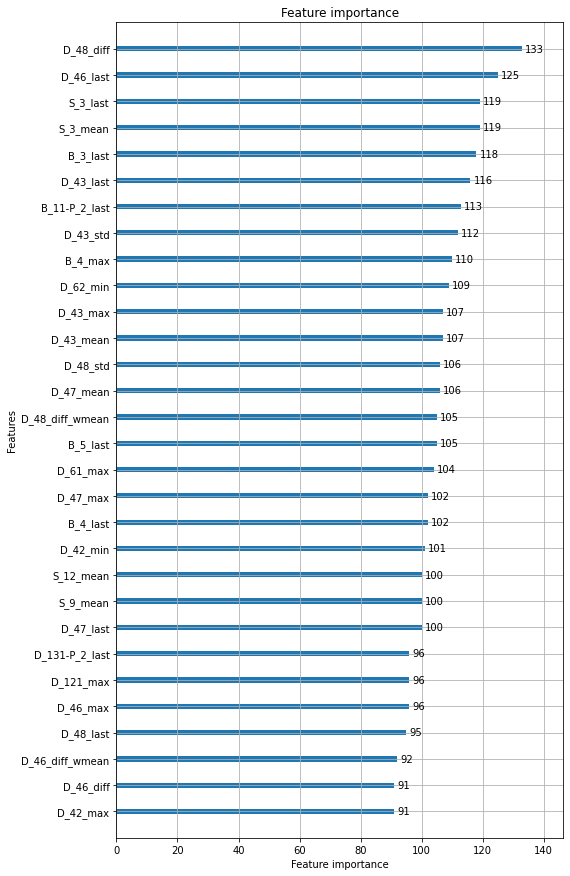

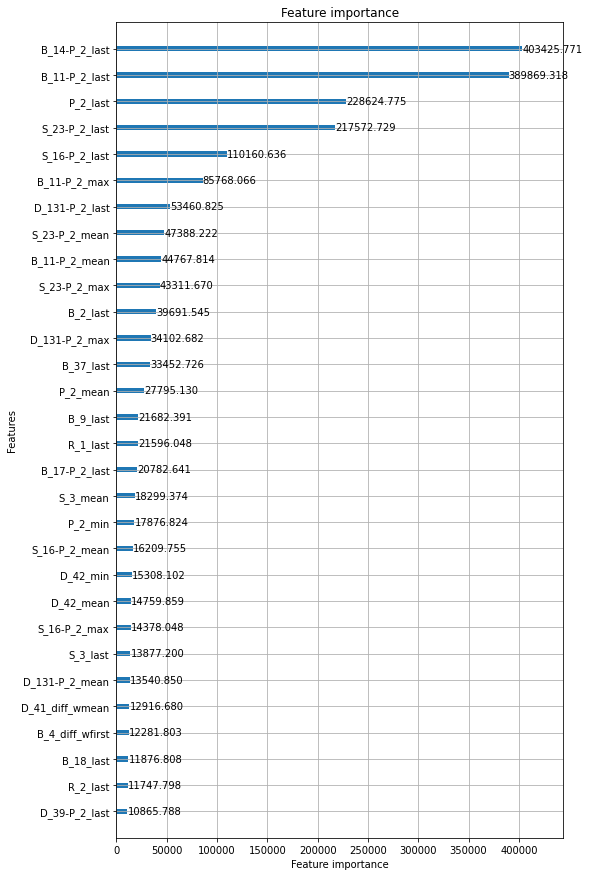

######################################## training model 4/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.765191	valid_0's recall_at4: 0.621881	valid_0's norm_gini: 0.9085


[100]	valid_0's amex_metric: 0.778299	valid_0's recall_at4: 0.641153	valid_0's norm_gini: 0.915445


[150]	valid_0's amex_metric: 0.785023	valid_0's recall_at4: 0.650999	valid_0's norm_gini: 0.919047


[200]	valid_0's amex_metric: 0.788349	valid_0's recall_at4: 0.655796	valid_0's norm_gini: 0.920901


[250]	valid_0's amex_metric: 0.790901	valid_0's recall_at4: 0.65971	valid_0's norm_gini: 0.922092


[300]	valid_0's amex_metric: 0.792617	valid_0's recall_at4: 0.662361	valid_0's norm_gini: 0.922872


[350]	valid_0's amex_metric: 0.794095	valid_0's recall_at4: 0.664801	valid_0's norm_gini: 0.923389


[400]	valid_0's amex_metric: 0.795472	valid_0's recall_at4: 0.6672	valid_0's norm_gini: 0.923744


[450]	valid_0's amex_metric: 0.796415	valid_0's recall_at4: 0.668757	valid_0's norm_gini: 0.924074


[500]	valid_0's amex_metric: 0.7968	valid_0's recall_at4: 0.669304	valid_0's norm_gini: 0.924297


[550]	valid_0's amex_metric: 0.796351	valid_0's recall_at4: 0.66821	valid_0's norm_gini: 0.924493


[600]	valid_0's amex_metric: 0.79693	valid_0's recall_at4: 0.669262	valid_0's norm_gini: 0.924598


[650]	valid_0's amex_metric: 0.796617	valid_0's recall_at4: 0.668546	valid_0's norm_gini: 0.924688


[700]	valid_0's amex_metric: 0.796837	valid_0's recall_at4: 0.668883	valid_0's norm_gini: 0.924791


[750]	valid_0's amex_metric: 0.797575	valid_0's recall_at4: 0.670313	valid_0's norm_gini: 0.924837


[800]	valid_0's amex_metric: 0.797726	valid_0's recall_at4: 0.670524	valid_0's norm_gini: 0.924927


[850]	valid_0's amex_metric: 0.797082	valid_0's recall_at4: 0.669177	valid_0's norm_gini: 0.924986


[900]	valid_0's amex_metric: 0.797999	valid_0's recall_at4: 0.670945	valid_0's norm_gini: 0.925054


[950]	valid_0's amex_metric: 0.797061	valid_0's recall_at4: 0.669051	valid_0's norm_gini: 0.925071


[1000]	valid_0's amex_metric: 0.797452	valid_0's recall_at4: 0.669766	valid_0's norm_gini: 0.925138


[1050]	valid_0's amex_metric: 0.797726	valid_0's recall_at4: 0.670313	valid_0's norm_gini: 0.925139


[1100]	valid_0's amex_metric: 0.797827	valid_0's recall_at4: 0.670482	valid_0's norm_gini: 0.925173


[1150]	valid_0's amex_metric: 0.797606	valid_0's recall_at4: 0.670019	valid_0's norm_gini: 0.925193


[1200]	valid_0's amex_metric: 0.797648	valid_0's recall_at4: 0.670145	valid_0's norm_gini: 0.925151


[1250]	valid_0's amex_metric: 0.797407	valid_0's recall_at4: 0.66964	valid_0's norm_gini: 0.925174


[1300]	valid_0's amex_metric: 0.797579	valid_0's recall_at4: 0.669977	valid_0's norm_gini: 0.925181


[1350]	valid_0's amex_metric: 0.797919	valid_0's recall_at4: 0.670692	valid_0's norm_gini: 0.925147


[1400]	valid_0's amex_metric: 0.797084	valid_0's recall_at4: 0.669009	valid_0's norm_gini: 0.925158


[1450]	valid_0's amex_metric: 0.797217	valid_0's recall_at4: 0.669262	valid_0's norm_gini: 0.925172


[1500]	valid_0's amex_metric: 0.796554	valid_0's recall_at4: 0.667957	valid_0's norm_gini: 0.925151


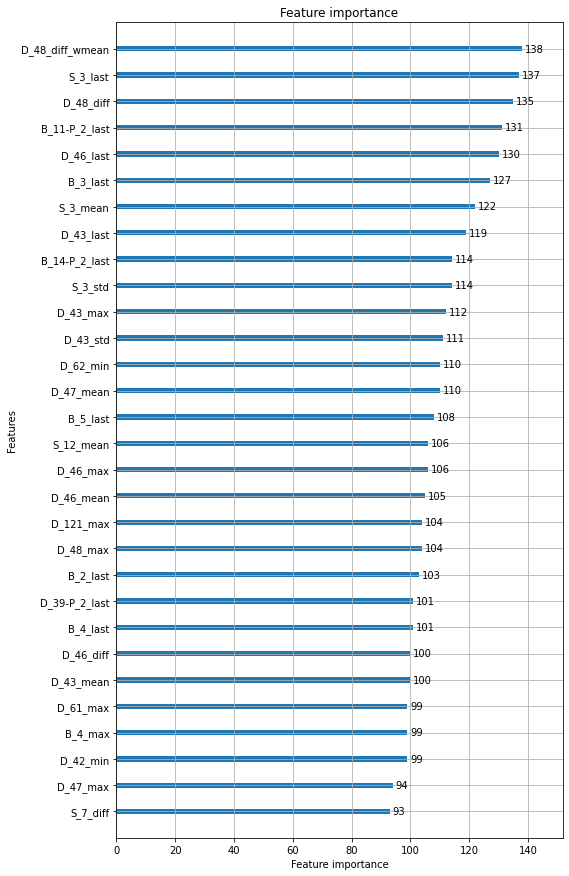

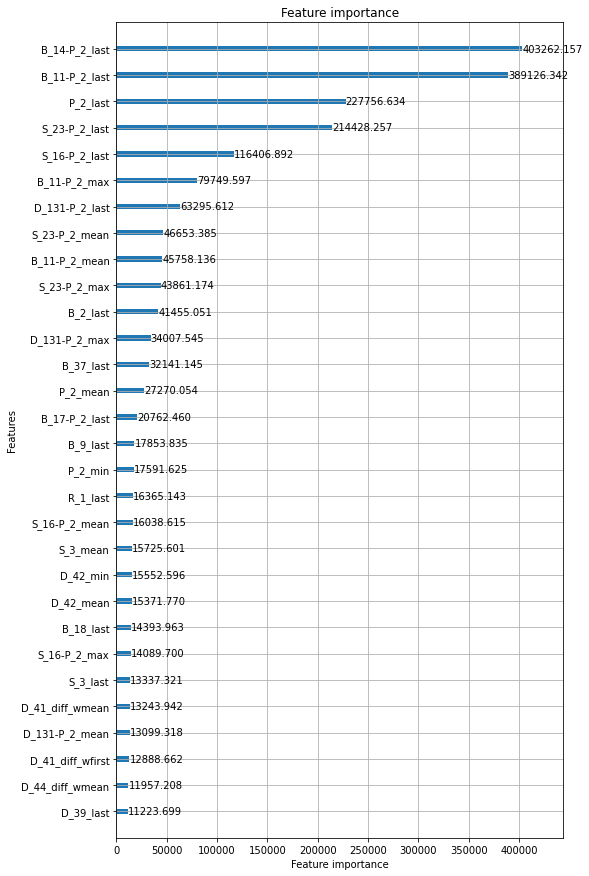

######################################## training model 5/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.766238	valid_0's recall_at4: 0.623564	valid_0's norm_gini: 0.908911


[100]	valid_0's amex_metric: 0.778295	valid_0's recall_at4: 0.640732	valid_0's norm_gini: 0.915857


[150]	valid_0's amex_metric: 0.78454	valid_0's recall_at4: 0.649695	valid_0's norm_gini: 0.919385


[200]	valid_0's amex_metric: 0.787491	valid_0's recall_at4: 0.65365	valid_0's norm_gini: 0.921332


[250]	valid_0's amex_metric: 0.789558	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.92252


[300]	valid_0's amex_metric: 0.789885	valid_0's recall_at4: 0.656554	valid_0's norm_gini: 0.923217


[350]	valid_0's amex_metric: 0.791548	valid_0's recall_at4: 0.659373	valid_0's norm_gini: 0.923722


[400]	valid_0's amex_metric: 0.79177	valid_0's recall_at4: 0.659499	valid_0's norm_gini: 0.924041


[450]	valid_0's amex_metric: 0.792655	valid_0's recall_at4: 0.661014	valid_0's norm_gini: 0.924296


[500]	valid_0's amex_metric: 0.792705	valid_0's recall_at4: 0.66093	valid_0's norm_gini: 0.924479


[550]	valid_0's amex_metric: 0.793708	valid_0's recall_at4: 0.662739	valid_0's norm_gini: 0.924677


[600]	valid_0's amex_metric: 0.794532	valid_0's recall_at4: 0.664212	valid_0's norm_gini: 0.924852


[650]	valid_0's amex_metric: 0.794707	valid_0's recall_at4: 0.664422	valid_0's norm_gini: 0.924992


[700]	valid_0's amex_metric: 0.794974	valid_0's recall_at4: 0.664885	valid_0's norm_gini: 0.925062


[750]	valid_0's amex_metric: 0.795171	valid_0's recall_at4: 0.665222	valid_0's norm_gini: 0.925119


[800]	valid_0's amex_metric: 0.795441	valid_0's recall_at4: 0.665685	valid_0's norm_gini: 0.925198


[850]	valid_0's amex_metric: 0.795778	valid_0's recall_at4: 0.666274	valid_0's norm_gini: 0.925281


[900]	valid_0's amex_metric: 0.795623	valid_0's recall_at4: 0.665895	valid_0's norm_gini: 0.92535


[950]	valid_0's amex_metric: 0.796003	valid_0's recall_at4: 0.666611	valid_0's norm_gini: 0.925396


[1000]	valid_0's amex_metric: 0.79587	valid_0's recall_at4: 0.666316	valid_0's norm_gini: 0.925424


[1050]	valid_0's amex_metric: 0.795945	valid_0's recall_at4: 0.666484	valid_0's norm_gini: 0.925406


[1100]	valid_0's amex_metric: 0.795733	valid_0's recall_at4: 0.666064	valid_0's norm_gini: 0.925403


[1150]	valid_0's amex_metric: 0.795245	valid_0's recall_at4: 0.665054	valid_0's norm_gini: 0.925437


[1200]	valid_0's amex_metric: 0.795825	valid_0's recall_at4: 0.66619	valid_0's norm_gini: 0.925459


[1250]	valid_0's amex_metric: 0.796306	valid_0's recall_at4: 0.667158	valid_0's norm_gini: 0.925453


[1300]	valid_0's amex_metric: 0.796424	valid_0's recall_at4: 0.667368	valid_0's norm_gini: 0.925481


[1350]	valid_0's amex_metric: 0.796703	valid_0's recall_at4: 0.667915	valid_0's norm_gini: 0.925492


[1400]	valid_0's amex_metric: 0.796643	valid_0's recall_at4: 0.667831	valid_0's norm_gini: 0.925456


[1450]	valid_0's amex_metric: 0.796987	valid_0's recall_at4: 0.668504	valid_0's norm_gini: 0.92547


[1500]	valid_0's amex_metric: 0.796863	valid_0's recall_at4: 0.668252	valid_0's norm_gini: 0.925474


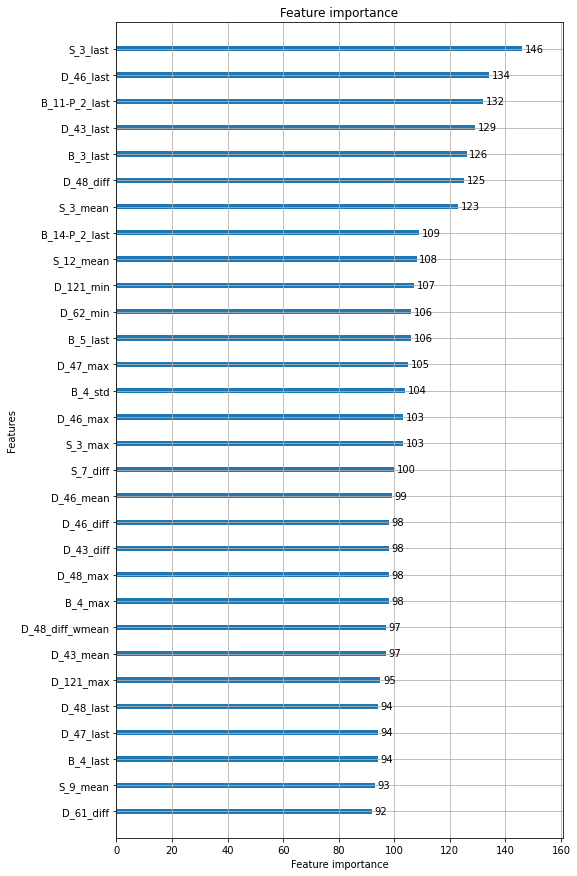

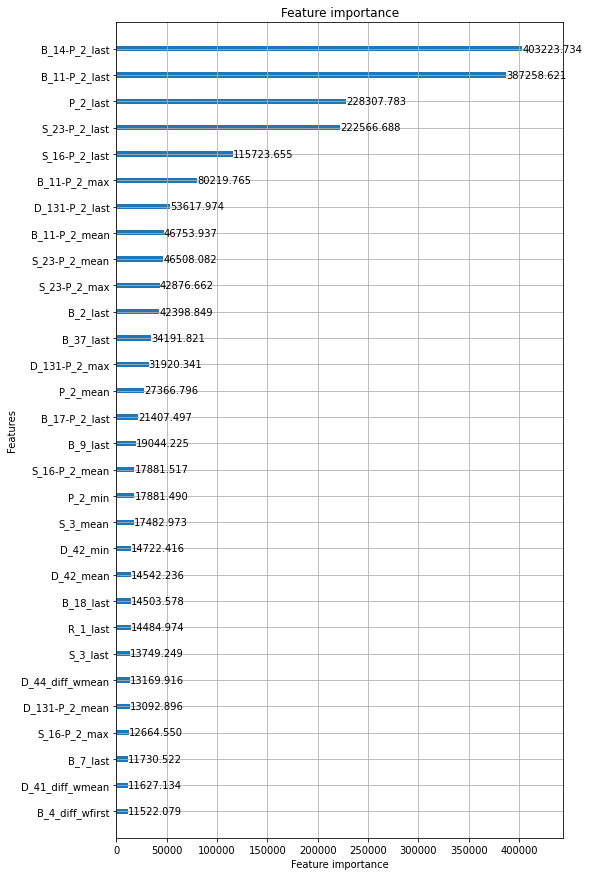

Training time: 27.35224041144053 min.
OOF recall_at4: 0.6646665769010671
OOF normalized_gini: 0.9244787023599457
OOF competition metric: 0.7945726396305064


############################### repeated cross-validation step: 3/5 ################################


######################################## training model 1/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.760015	valid_0's recall_at4: 0.613145	valid_0's norm_gini: 0.906885


[100]	valid_0's amex_metric: 0.774273	valid_0's recall_at4: 0.634478	valid_0's norm_gini: 0.914069


[150]	valid_0's amex_metric: 0.781454	valid_0's recall_at4: 0.64525	valid_0's norm_gini: 0.917658


[200]	valid_0's amex_metric: 0.785048	valid_0's recall_at4: 0.650551	valid_0's norm_gini: 0.919545


[250]	valid_0's amex_metric: 0.786917	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.920633


[300]	valid_0's amex_metric: 0.787815	valid_0's recall_at4: 0.654212	valid_0's norm_gini: 0.921419


[350]	valid_0's amex_metric: 0.788792	valid_0's recall_at4: 0.655685	valid_0's norm_gini: 0.9219


[400]	valid_0's amex_metric: 0.788659	valid_0's recall_at4: 0.655053	valid_0's norm_gini: 0.922265


[450]	valid_0's amex_metric: 0.789479	valid_0's recall_at4: 0.656358	valid_0's norm_gini: 0.9226


[500]	valid_0's amex_metric: 0.791063	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.922823


[550]	valid_0's amex_metric: 0.790917	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.922951


[600]	valid_0's amex_metric: 0.791592	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.923081


[650]	valid_0's amex_metric: 0.791877	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.923188


[700]	valid_0's amex_metric: 0.791895	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.923266


[750]	valid_0's amex_metric: 0.791316	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.923329


[800]	valid_0's amex_metric: 0.79198	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.923395


[850]	valid_0's amex_metric: 0.79207	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.923407


[900]	valid_0's amex_metric: 0.792162	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.923422


[950]	valid_0's amex_metric: 0.791406	valid_0's recall_at4: 0.659387	valid_0's norm_gini: 0.923424


[1000]	valid_0's amex_metric: 0.791772	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.923441


[1050]	valid_0's amex_metric: 0.7919	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.923487


[1100]	valid_0's amex_metric: 0.79188	valid_0's recall_at4: 0.660271	valid_0's norm_gini: 0.923488


[1150]	valid_0's amex_metric: 0.791926	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.92354


[1200]	valid_0's amex_metric: 0.791838	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.923573


[1250]	valid_0's amex_metric: 0.791631	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.923581


[1300]	valid_0's amex_metric: 0.79115	valid_0's recall_at4: 0.658714	valid_0's norm_gini: 0.923586


[1350]	valid_0's amex_metric: 0.791321	valid_0's recall_at4: 0.659051	valid_0's norm_gini: 0.923591


[1400]	valid_0's amex_metric: 0.792055	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.923587


[1450]	valid_0's amex_metric: 0.792292	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.923598


[1500]	valid_0's amex_metric: 0.792131	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.923612


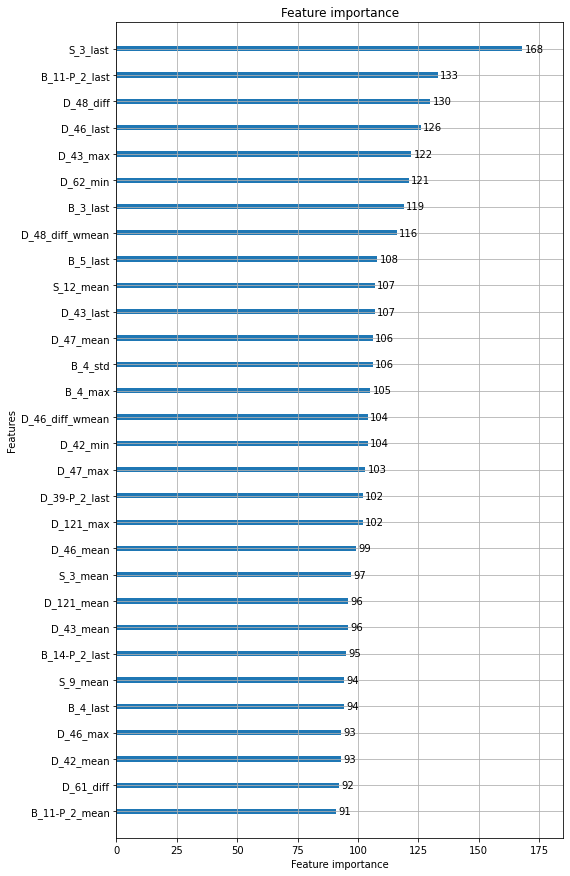

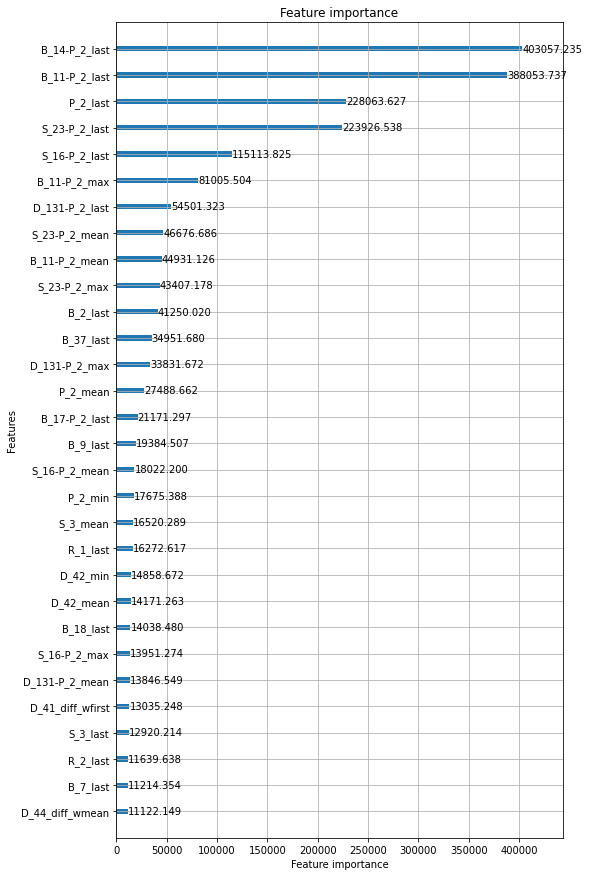

######################################## training model 2/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.762126	valid_0's recall_at4: 0.615964	valid_0's norm_gini: 0.908288


[100]	valid_0's amex_metric: 0.771639	valid_0's recall_at4: 0.628293	valid_0's norm_gini: 0.914985


[150]	valid_0's amex_metric: 0.779487	valid_0's recall_at4: 0.640369	valid_0's norm_gini: 0.918605


[200]	valid_0's amex_metric: 0.782575	valid_0's recall_at4: 0.644618	valid_0's norm_gini: 0.920532


[250]	valid_0's amex_metric: 0.784661	valid_0's recall_at4: 0.647606	valid_0's norm_gini: 0.921716


[300]	valid_0's amex_metric: 0.78685	valid_0's recall_at4: 0.651224	valid_0's norm_gini: 0.922475


[350]	valid_0's amex_metric: 0.787871	valid_0's recall_at4: 0.652739	valid_0's norm_gini: 0.923003


[400]	valid_0's amex_metric: 0.788706	valid_0's recall_at4: 0.654044	valid_0's norm_gini: 0.923369


[450]	valid_0's amex_metric: 0.788705	valid_0's recall_at4: 0.653707	valid_0's norm_gini: 0.923703


[500]	valid_0's amex_metric: 0.789071	valid_0's recall_at4: 0.654212	valid_0's norm_gini: 0.923929


[550]	valid_0's amex_metric: 0.789619	valid_0's recall_at4: 0.655138	valid_0's norm_gini: 0.924101


[600]	valid_0's amex_metric: 0.789874	valid_0's recall_at4: 0.655474	valid_0's norm_gini: 0.924274


[650]	valid_0's amex_metric: 0.789103	valid_0's recall_at4: 0.653791	valid_0's norm_gini: 0.924415


[700]	valid_0's amex_metric: 0.790011	valid_0's recall_at4: 0.655516	valid_0's norm_gini: 0.924506


[750]	valid_0's amex_metric: 0.789471	valid_0's recall_at4: 0.654338	valid_0's norm_gini: 0.924603


[800]	valid_0's amex_metric: 0.789697	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.924719


[850]	valid_0's amex_metric: 0.78933	valid_0's recall_at4: 0.653875	valid_0's norm_gini: 0.924785


[900]	valid_0's amex_metric: 0.789478	valid_0's recall_at4: 0.654128	valid_0's norm_gini: 0.924828


[950]	valid_0's amex_metric: 0.79003	valid_0's recall_at4: 0.655222	valid_0's norm_gini: 0.924839


[1000]	valid_0's amex_metric: 0.78957	valid_0's recall_at4: 0.654254	valid_0's norm_gini: 0.924886


[1050]	valid_0's amex_metric: 0.789882	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.92488


[1100]	valid_0's amex_metric: 0.789859	valid_0's recall_at4: 0.654843	valid_0's norm_gini: 0.924874


[1150]	valid_0's amex_metric: 0.789623	valid_0's recall_at4: 0.654338	valid_0's norm_gini: 0.924908


[1200]	valid_0's amex_metric: 0.789848	valid_0's recall_at4: 0.654801	valid_0's norm_gini: 0.924896


[1250]	valid_0's amex_metric: 0.789642	valid_0's recall_at4: 0.65438	valid_0's norm_gini: 0.924904


[1300]	valid_0's amex_metric: 0.789844	valid_0's recall_at4: 0.654759	valid_0's norm_gini: 0.924929


[1350]	valid_0's amex_metric: 0.789403	valid_0's recall_at4: 0.653917	valid_0's norm_gini: 0.924888


[1400]	valid_0's amex_metric: 0.789203	valid_0's recall_at4: 0.653497	valid_0's norm_gini: 0.92491


[1450]	valid_0's amex_metric: 0.78965	valid_0's recall_at4: 0.65438	valid_0's norm_gini: 0.92492


[1500]	valid_0's amex_metric: 0.78949	valid_0's recall_at4: 0.654044	valid_0's norm_gini: 0.924936


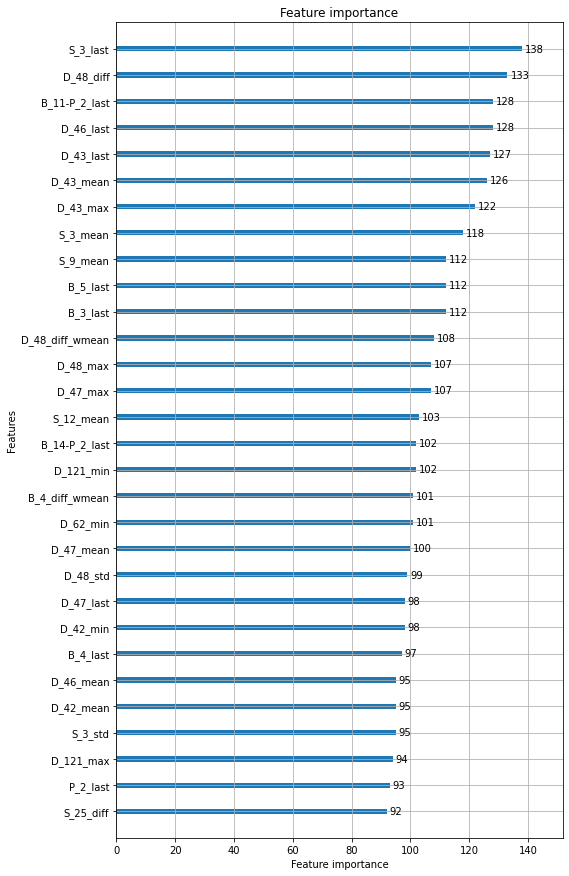

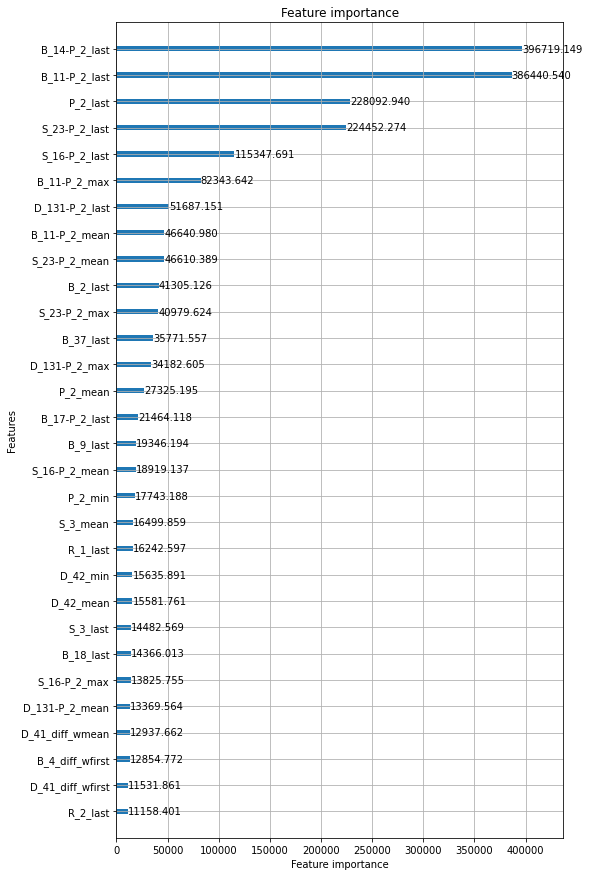

######################################## training model 3/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.763376	valid_0's recall_at4: 0.619835	valid_0's norm_gini: 0.906916


[100]	valid_0's amex_metric: 0.776323	valid_0's recall_at4: 0.638139	valid_0's norm_gini: 0.914508


[150]	valid_0's amex_metric: 0.783782	valid_0's recall_at4: 0.649163	valid_0's norm_gini: 0.9184


[200]	valid_0's amex_metric: 0.786676	valid_0's recall_at4: 0.652823	valid_0's norm_gini: 0.920529


[250]	valid_0's amex_metric: 0.789428	valid_0's recall_at4: 0.657073	valid_0's norm_gini: 0.921783


[300]	valid_0's amex_metric: 0.791884	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.922656


[350]	valid_0's amex_metric: 0.79383	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.923181


[400]	valid_0's amex_metric: 0.794596	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.923577


[450]	valid_0's amex_metric: 0.795892	valid_0's recall_at4: 0.667887	valid_0's norm_gini: 0.923897


[500]	valid_0's amex_metric: 0.796118	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.924098


[550]	valid_0's amex_metric: 0.796096	valid_0's recall_at4: 0.667929	valid_0's norm_gini: 0.924263


[600]	valid_0's amex_metric: 0.796686	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.924391


[650]	valid_0's amex_metric: 0.797427	valid_0's recall_at4: 0.670327	valid_0's norm_gini: 0.924526


[700]	valid_0's amex_metric: 0.79743	valid_0's recall_at4: 0.670243	valid_0's norm_gini: 0.924618


[750]	valid_0's amex_metric: 0.797177	valid_0's recall_at4: 0.669612	valid_0's norm_gini: 0.924742


[800]	valid_0's amex_metric: 0.797152	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.924819


[850]	valid_0's amex_metric: 0.797002	valid_0's recall_at4: 0.669149	valid_0's norm_gini: 0.924854


[900]	valid_0's amex_metric: 0.797007	valid_0's recall_at4: 0.669107	valid_0's norm_gini: 0.924907


[950]	valid_0's amex_metric: 0.796961	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.924942


[1000]	valid_0's amex_metric: 0.796783	valid_0's recall_at4: 0.668602	valid_0's norm_gini: 0.924964


[1050]	valid_0's amex_metric: 0.7972	valid_0's recall_at4: 0.669402	valid_0's norm_gini: 0.924998


[1100]	valid_0's amex_metric: 0.797199	valid_0's recall_at4: 0.669402	valid_0's norm_gini: 0.924997


[1150]	valid_0's amex_metric: 0.797395	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.924967


[1200]	valid_0's amex_metric: 0.796872	valid_0's recall_at4: 0.66877	valid_0's norm_gini: 0.924973


[1250]	valid_0's amex_metric: 0.796888	valid_0's recall_at4: 0.668813	valid_0's norm_gini: 0.924964


[1300]	valid_0's amex_metric: 0.79761	valid_0's recall_at4: 0.670243	valid_0's norm_gini: 0.924977


[1350]	valid_0's amex_metric: 0.796753	valid_0's recall_at4: 0.668518	valid_0's norm_gini: 0.924988


[1400]	valid_0's amex_metric: 0.796599	valid_0's recall_at4: 0.668224	valid_0's norm_gini: 0.924974


[1450]	valid_0's amex_metric: 0.796416	valid_0's recall_at4: 0.667887	valid_0's norm_gini: 0.924945


[1500]	valid_0's amex_metric: 0.796535	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.924931


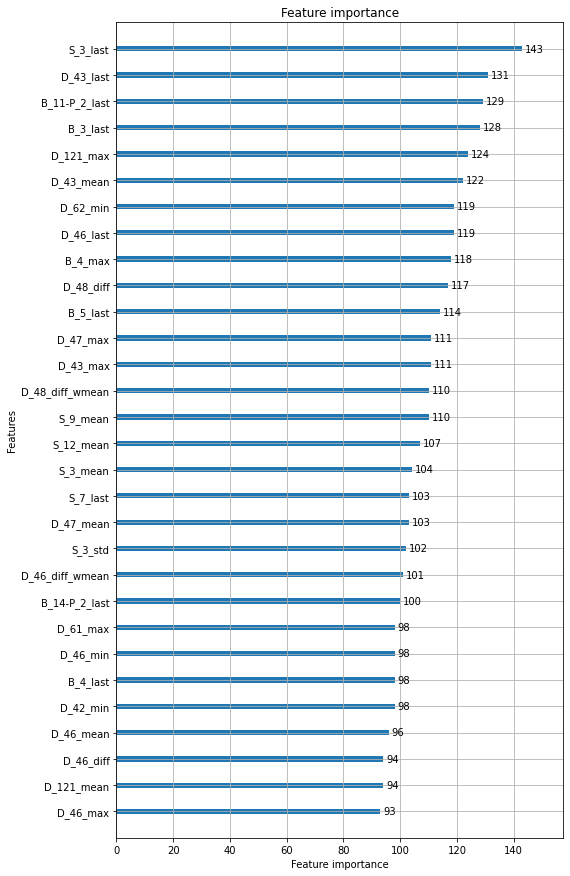

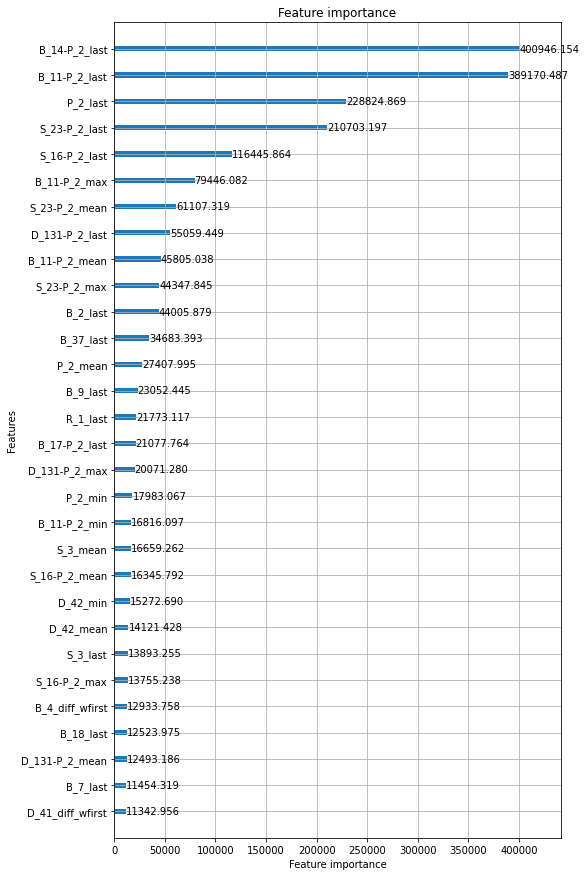

######################################## training model 4/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.768774	valid_0's recall_at4: 0.626594	valid_0's norm_gini: 0.910955


[100]	valid_0's amex_metric: 0.781678	valid_0's recall_at4: 0.645403	valid_0's norm_gini: 0.917953


[150]	valid_0's amex_metric: 0.788851	valid_0's recall_at4: 0.656007	valid_0's norm_gini: 0.921695


[200]	valid_0's amex_metric: 0.792302	valid_0's recall_at4: 0.661014	valid_0's norm_gini: 0.92359


[250]	valid_0's amex_metric: 0.794656	valid_0's recall_at4: 0.664507	valid_0's norm_gini: 0.924806


[300]	valid_0's amex_metric: 0.796221	valid_0's recall_at4: 0.666905	valid_0's norm_gini: 0.925537


[350]	valid_0's amex_metric: 0.797683	valid_0's recall_at4: 0.669262	valid_0's norm_gini: 0.926104


[400]	valid_0's amex_metric: 0.797888	valid_0's recall_at4: 0.669304	valid_0's norm_gini: 0.926472


[450]	valid_0's amex_metric: 0.799071	valid_0's recall_at4: 0.671408	valid_0's norm_gini: 0.926735


[500]	valid_0's amex_metric: 0.799971	valid_0's recall_at4: 0.673049	valid_0's norm_gini: 0.926894


[550]	valid_0's amex_metric: 0.79987	valid_0's recall_at4: 0.672712	valid_0's norm_gini: 0.927029


[600]	valid_0's amex_metric: 0.800218	valid_0's recall_at4: 0.673301	valid_0's norm_gini: 0.927135


[650]	valid_0's amex_metric: 0.800457	valid_0's recall_at4: 0.67368	valid_0's norm_gini: 0.927235


[700]	valid_0's amex_metric: 0.800001	valid_0's recall_at4: 0.67267	valid_0's norm_gini: 0.927332


[750]	valid_0's amex_metric: 0.800538	valid_0's recall_at4: 0.67368	valid_0's norm_gini: 0.927395


[800]	valid_0's amex_metric: 0.800325	valid_0's recall_at4: 0.673217	valid_0's norm_gini: 0.927434


[850]	valid_0's amex_metric: 0.800775	valid_0's recall_at4: 0.674058	valid_0's norm_gini: 0.927491


[900]	valid_0's amex_metric: 0.80059	valid_0's recall_at4: 0.673638	valid_0's norm_gini: 0.927542


[950]	valid_0's amex_metric: 0.801494	valid_0's recall_at4: 0.675405	valid_0's norm_gini: 0.927584


[1000]	valid_0's amex_metric: 0.800939	valid_0's recall_at4: 0.674269	valid_0's norm_gini: 0.927608


[1050]	valid_0's amex_metric: 0.800366	valid_0's recall_at4: 0.673091	valid_0's norm_gini: 0.927642


[1100]	valid_0's amex_metric: 0.800509	valid_0's recall_at4: 0.673343	valid_0's norm_gini: 0.927674


[1150]	valid_0's amex_metric: 0.80143	valid_0's recall_at4: 0.675195	valid_0's norm_gini: 0.927665


[1200]	valid_0's amex_metric: 0.801549	valid_0's recall_at4: 0.675405	valid_0's norm_gini: 0.927693


[1250]	valid_0's amex_metric: 0.80125	valid_0's recall_at4: 0.674774	valid_0's norm_gini: 0.927726


[1300]	valid_0's amex_metric: 0.801319	valid_0's recall_at4: 0.6749	valid_0's norm_gini: 0.927737


[1350]	valid_0's amex_metric: 0.800874	valid_0's recall_at4: 0.673974	valid_0's norm_gini: 0.927775


[1400]	valid_0's amex_metric: 0.801341	valid_0's recall_at4: 0.6749	valid_0's norm_gini: 0.927782


[1450]	valid_0's amex_metric: 0.801312	valid_0's recall_at4: 0.674858	valid_0's norm_gini: 0.927767


[1500]	valid_0's amex_metric: 0.800835	valid_0's recall_at4: 0.673932	valid_0's norm_gini: 0.927738


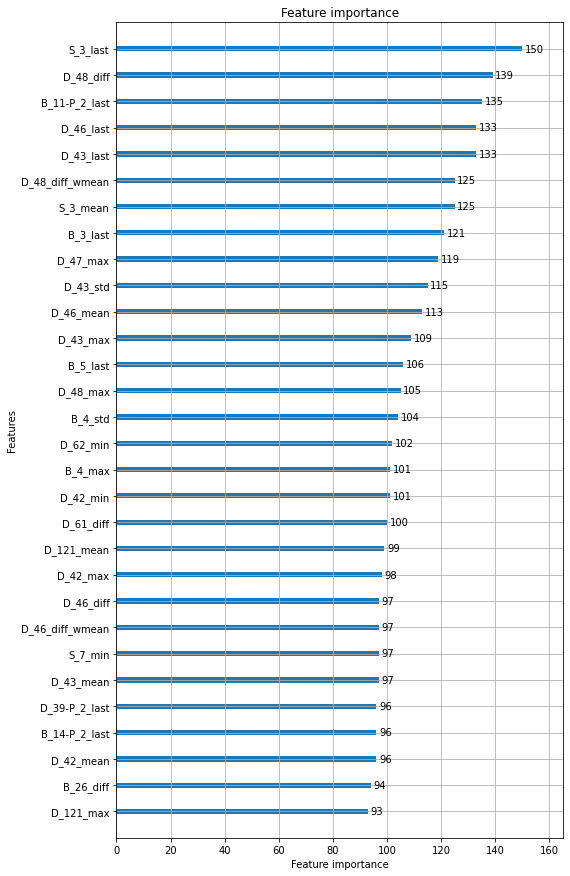

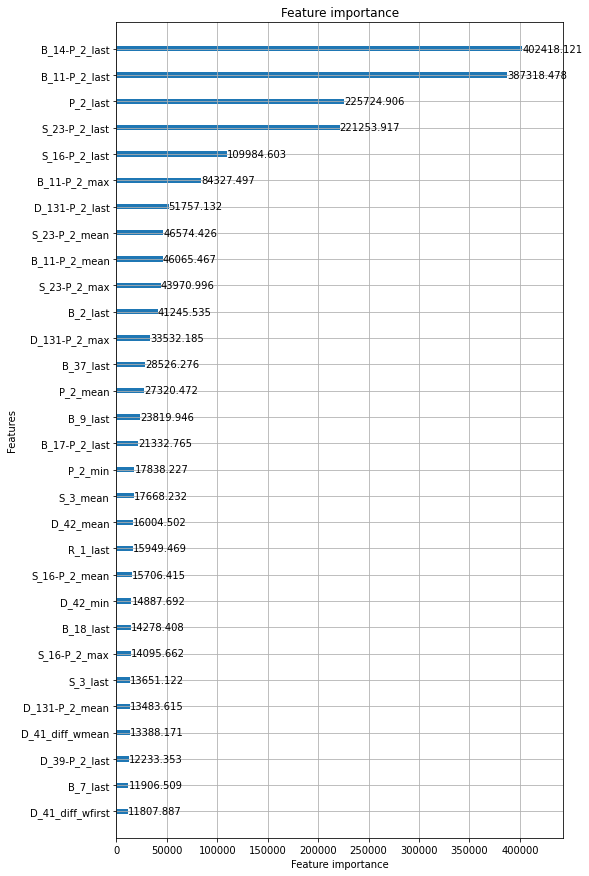

######################################## training model 5/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.765339	valid_0's recall_at4: 0.623059	valid_0's norm_gini: 0.907619


[100]	valid_0's amex_metric: 0.77707	valid_0's recall_at4: 0.639554	valid_0's norm_gini: 0.914587


[150]	valid_0's amex_metric: 0.783113	valid_0's recall_at4: 0.64818	valid_0's norm_gini: 0.918046


[200]	valid_0's amex_metric: 0.785881	valid_0's recall_at4: 0.651799	valid_0's norm_gini: 0.919964


[250]	valid_0's amex_metric: 0.787661	valid_0's recall_at4: 0.654239	valid_0's norm_gini: 0.921082


[300]	valid_0's amex_metric: 0.788449	valid_0's recall_at4: 0.655081	valid_0's norm_gini: 0.921817


[350]	valid_0's amex_metric: 0.789507	valid_0's recall_at4: 0.65668	valid_0's norm_gini: 0.922334


[400]	valid_0's amex_metric: 0.790274	valid_0's recall_at4: 0.657858	valid_0's norm_gini: 0.922689


[450]	valid_0's amex_metric: 0.790809	valid_0's recall_at4: 0.658658	valid_0's norm_gini: 0.92296


[500]	valid_0's amex_metric: 0.791064	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.923217


[550]	valid_0's amex_metric: 0.791675	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.923387


[600]	valid_0's amex_metric: 0.792338	valid_0's recall_at4: 0.661182	valid_0's norm_gini: 0.923494


[650]	valid_0's amex_metric: 0.792376	valid_0's recall_at4: 0.66114	valid_0's norm_gini: 0.923612


[700]	valid_0's amex_metric: 0.792579	valid_0's recall_at4: 0.661477	valid_0's norm_gini: 0.923681


[750]	valid_0's amex_metric: 0.79258	valid_0's recall_at4: 0.661393	valid_0's norm_gini: 0.923768


[800]	valid_0's amex_metric: 0.793227	valid_0's recall_at4: 0.662613	valid_0's norm_gini: 0.923842


[850]	valid_0's amex_metric: 0.792967	valid_0's recall_at4: 0.662024	valid_0's norm_gini: 0.923909


[900]	valid_0's amex_metric: 0.793451	valid_0's recall_at4: 0.66295	valid_0's norm_gini: 0.923953


[950]	valid_0's amex_metric: 0.793687	valid_0's recall_at4: 0.66337	valid_0's norm_gini: 0.924003


[1000]	valid_0's amex_metric: 0.793999	valid_0's recall_at4: 0.66396	valid_0's norm_gini: 0.924038


[1050]	valid_0's amex_metric: 0.793749	valid_0's recall_at4: 0.663455	valid_0's norm_gini: 0.924043


[1100]	valid_0's amex_metric: 0.793841	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.924058


[1150]	valid_0's amex_metric: 0.794021	valid_0's recall_at4: 0.66396	valid_0's norm_gini: 0.924082


[1200]	valid_0's amex_metric: 0.793973	valid_0's recall_at4: 0.663833	valid_0's norm_gini: 0.924113


[1250]	valid_0's amex_metric: 0.793555	valid_0's recall_at4: 0.662992	valid_0's norm_gini: 0.924119


[1300]	valid_0's amex_metric: 0.794096	valid_0's recall_at4: 0.664044	valid_0's norm_gini: 0.924148


[1350]	valid_0's amex_metric: 0.793531	valid_0's recall_at4: 0.66295	valid_0's norm_gini: 0.924113


[1400]	valid_0's amex_metric: 0.793877	valid_0's recall_at4: 0.663665	valid_0's norm_gini: 0.92409


[1450]	valid_0's amex_metric: 0.79313	valid_0's recall_at4: 0.662192	valid_0's norm_gini: 0.924067


[1500]	valid_0's amex_metric: 0.79306	valid_0's recall_at4: 0.662066	valid_0's norm_gini: 0.924053


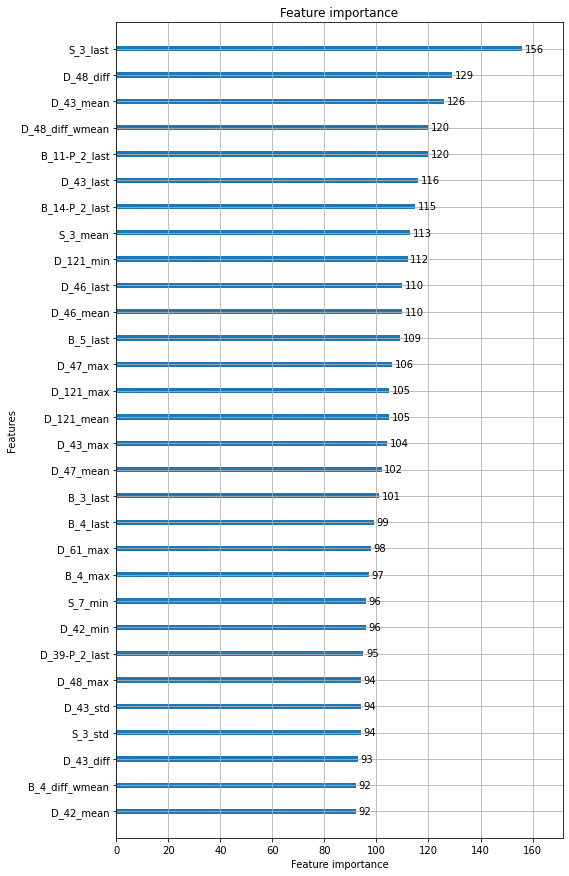

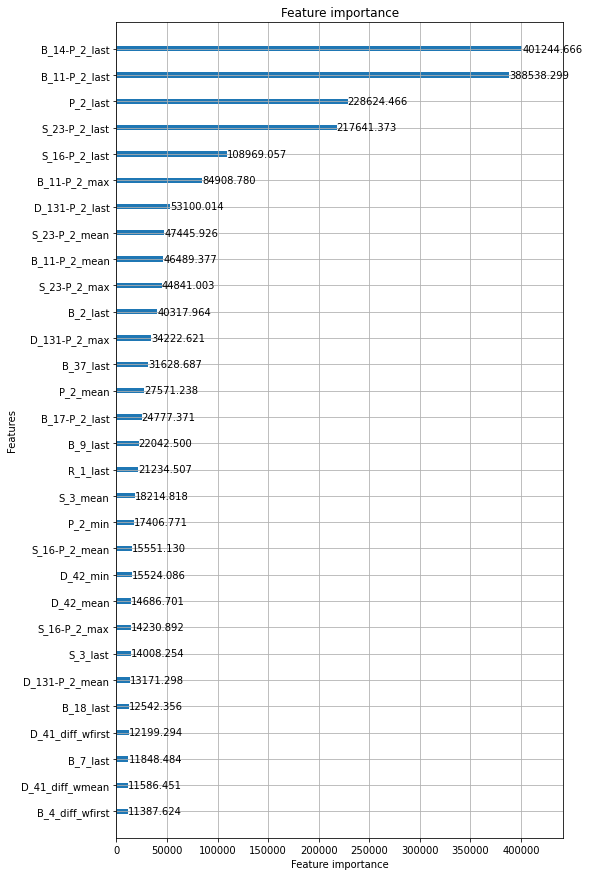

Training time: 27.27793219089508 min.
OOF recall_at4: 0.664043828053994
OOF normalized_gini: 0.9245885475516392
OOF competition metric: 0.7943161878028167


############################### repeated cross-validation step: 4/5 ################################


######################################## training model 1/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.760549	valid_0's recall_at4: 0.614954	valid_0's norm_gini: 0.906144


[100]	valid_0's amex_metric: 0.774448	valid_0's recall_at4: 0.635404	valid_0's norm_gini: 0.913493


[150]	valid_0's amex_metric: 0.780391	valid_0's recall_at4: 0.643609	valid_0's norm_gini: 0.917173


[200]	valid_0's amex_metric: 0.783945	valid_0's recall_at4: 0.6487	valid_0's norm_gini: 0.91919


[250]	valid_0's amex_metric: 0.786418	valid_0's recall_at4: 0.652403	valid_0's norm_gini: 0.920434


[300]	valid_0's amex_metric: 0.78725	valid_0's recall_at4: 0.65337	valid_0's norm_gini: 0.92113


[350]	valid_0's amex_metric: 0.788148	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.921621


[400]	valid_0's amex_metric: 0.789168	valid_0's recall_at4: 0.656358	valid_0's norm_gini: 0.921978


[450]	valid_0's amex_metric: 0.789588	valid_0's recall_at4: 0.656947	valid_0's norm_gini: 0.92223


[500]	valid_0's amex_metric: 0.79011	valid_0's recall_at4: 0.657746	valid_0's norm_gini: 0.922473


[550]	valid_0's amex_metric: 0.789762	valid_0's recall_at4: 0.656905	valid_0's norm_gini: 0.922619


[600]	valid_0's amex_metric: 0.789944	valid_0's recall_at4: 0.657157	valid_0's norm_gini: 0.922731


[650]	valid_0's amex_metric: 0.789991	valid_0's recall_at4: 0.657157	valid_0's norm_gini: 0.922825


[700]	valid_0's amex_metric: 0.79004	valid_0's recall_at4: 0.657199	valid_0's norm_gini: 0.922881


[750]	valid_0's amex_metric: 0.789736	valid_0's recall_at4: 0.656526	valid_0's norm_gini: 0.922946


[800]	valid_0's amex_metric: 0.789677	valid_0's recall_at4: 0.656358	valid_0's norm_gini: 0.922995


[850]	valid_0's amex_metric: 0.789681	valid_0's recall_at4: 0.656358	valid_0's norm_gini: 0.923004


[900]	valid_0's amex_metric: 0.790102	valid_0's recall_at4: 0.657157	valid_0's norm_gini: 0.923047


[950]	valid_0's amex_metric: 0.789871	valid_0's recall_at4: 0.656694	valid_0's norm_gini: 0.923047


[1000]	valid_0's amex_metric: 0.789298	valid_0's recall_at4: 0.655516	valid_0's norm_gini: 0.923079


[1050]	valid_0's amex_metric: 0.789688	valid_0's recall_at4: 0.656232	valid_0's norm_gini: 0.923145


[1100]	valid_0's amex_metric: 0.790039	valid_0's recall_at4: 0.656947	valid_0's norm_gini: 0.923131


[1150]	valid_0's amex_metric: 0.79004	valid_0's recall_at4: 0.656947	valid_0's norm_gini: 0.923133


[1200]	valid_0's amex_metric: 0.790393	valid_0's recall_at4: 0.657662	valid_0's norm_gini: 0.923124


[1250]	valid_0's amex_metric: 0.790355	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.923132


[1300]	valid_0's amex_metric: 0.7912	valid_0's recall_at4: 0.659261	valid_0's norm_gini: 0.923139


[1350]	valid_0's amex_metric: 0.790604	valid_0's recall_at4: 0.658083	valid_0's norm_gini: 0.923126


[1400]	valid_0's amex_metric: 0.791236	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.923168


[1450]	valid_0's amex_metric: 0.790643	valid_0's recall_at4: 0.658125	valid_0's norm_gini: 0.923162


[1500]	valid_0's amex_metric: 0.790478	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.923167


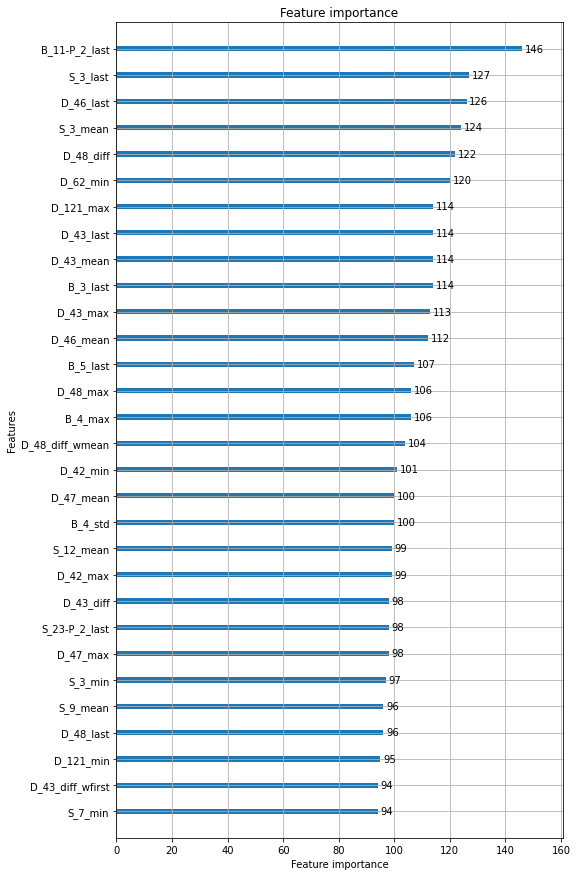

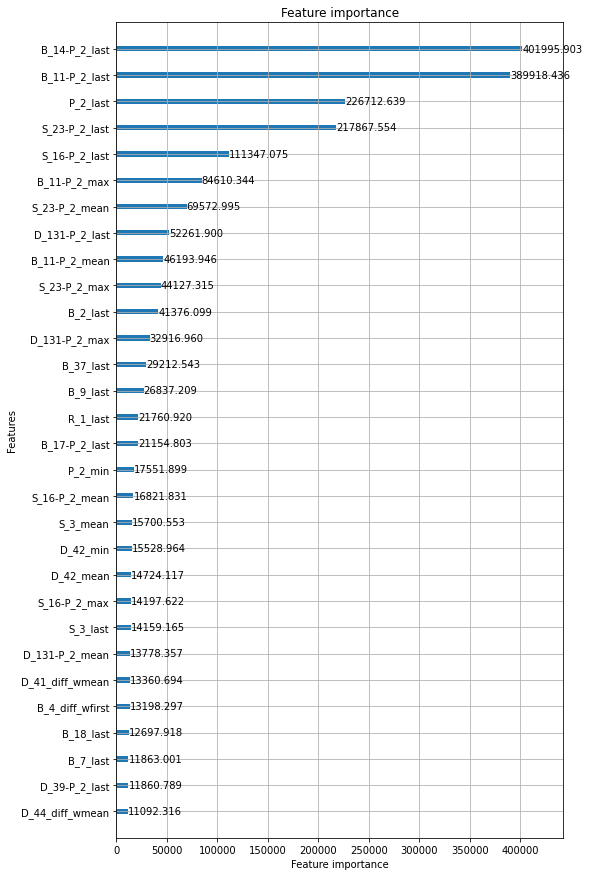

######################################## training model 2/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.765988	valid_0's recall_at4: 0.62257	valid_0's norm_gini: 0.909406


[100]	valid_0's amex_metric: 0.777411	valid_0's recall_at4: 0.638686	valid_0's norm_gini: 0.916136


[150]	valid_0's amex_metric: 0.784551	valid_0's recall_at4: 0.649373	valid_0's norm_gini: 0.919729


[200]	valid_0's amex_metric: 0.789163	valid_0's recall_at4: 0.656694	valid_0's norm_gini: 0.921632


[250]	valid_0's amex_metric: 0.791655	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.922744


[300]	valid_0's amex_metric: 0.793109	valid_0's recall_at4: 0.662754	valid_0's norm_gini: 0.923465


[350]	valid_0's amex_metric: 0.793772	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.923991


[400]	valid_0's amex_metric: 0.794449	valid_0's recall_at4: 0.664521	valid_0's norm_gini: 0.924376


[450]	valid_0's amex_metric: 0.795523	valid_0's recall_at4: 0.666414	valid_0's norm_gini: 0.924632


[500]	valid_0's amex_metric: 0.796272	valid_0's recall_at4: 0.667719	valid_0's norm_gini: 0.924825


[550]	valid_0's amex_metric: 0.796456	valid_0's recall_at4: 0.667929	valid_0's norm_gini: 0.924983


[600]	valid_0's amex_metric: 0.796849	valid_0's recall_at4: 0.66856	valid_0's norm_gini: 0.925137


[650]	valid_0's amex_metric: 0.796668	valid_0's recall_at4: 0.668097	valid_0's norm_gini: 0.925239


[700]	valid_0's amex_metric: 0.796022	valid_0's recall_at4: 0.666709	valid_0's norm_gini: 0.925335


[750]	valid_0's amex_metric: 0.796354	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.925411


[800]	valid_0's amex_metric: 0.795999	valid_0's recall_at4: 0.66654	valid_0's norm_gini: 0.925458


[850]	valid_0's amex_metric: 0.796768	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.925523


[900]	valid_0's amex_metric: 0.795815	valid_0's recall_at4: 0.666036	valid_0's norm_gini: 0.925594


[950]	valid_0's amex_metric: 0.795555	valid_0's recall_at4: 0.665489	valid_0's norm_gini: 0.925621


[1000]	valid_0's amex_metric: 0.796328	valid_0's recall_at4: 0.667003	valid_0's norm_gini: 0.925654


[1050]	valid_0's amex_metric: 0.796515	valid_0's recall_at4: 0.66734	valid_0's norm_gini: 0.925691


[1100]	valid_0's amex_metric: 0.796743	valid_0's recall_at4: 0.667803	valid_0's norm_gini: 0.925683


[1150]	valid_0's amex_metric: 0.797155	valid_0's recall_at4: 0.668644	valid_0's norm_gini: 0.925665


[1200]	valid_0's amex_metric: 0.796834	valid_0's recall_at4: 0.667971	valid_0's norm_gini: 0.925698


[1250]	valid_0's amex_metric: 0.797075	valid_0's recall_at4: 0.668434	valid_0's norm_gini: 0.925716


[1300]	valid_0's amex_metric: 0.79725	valid_0's recall_at4: 0.66877	valid_0's norm_gini: 0.92573


[1350]	valid_0's amex_metric: 0.79761	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.925735


[1400]	valid_0's amex_metric: 0.798165	valid_0's recall_at4: 0.67058	valid_0's norm_gini: 0.925749


[1450]	valid_0's amex_metric: 0.797192	valid_0's recall_at4: 0.668644	valid_0's norm_gini: 0.92574


[1500]	valid_0's amex_metric: 0.797094	valid_0's recall_at4: 0.668476	valid_0's norm_gini: 0.925712


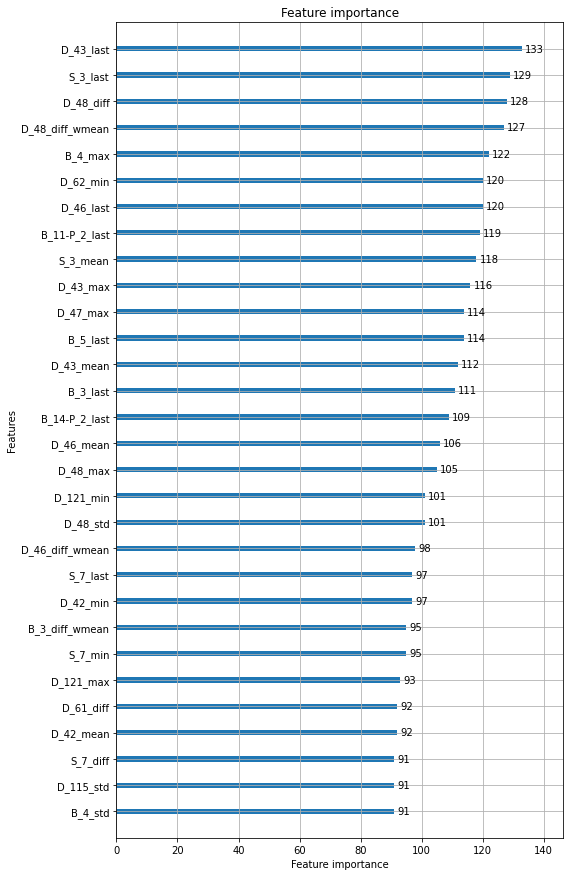

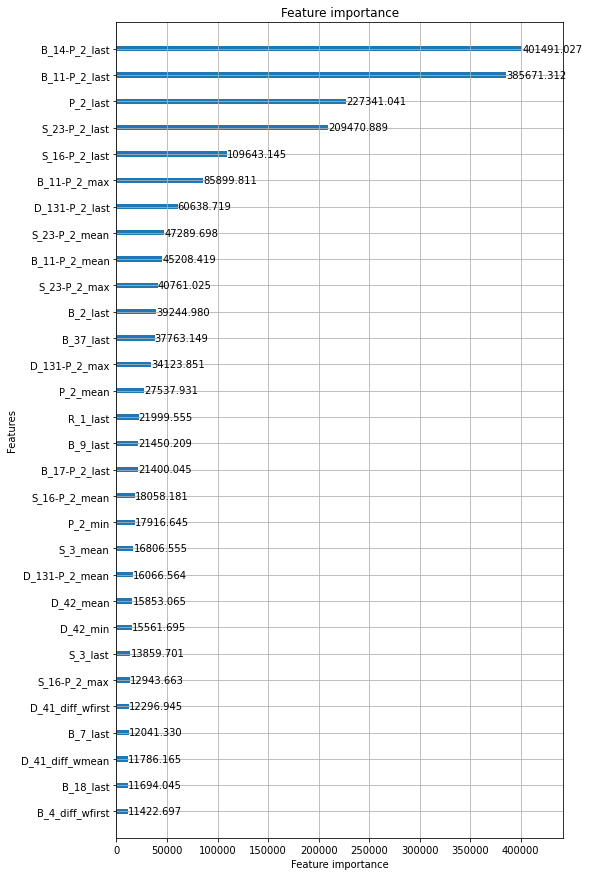

######################################## training model 3/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.76539	valid_0's recall_at4: 0.621097	valid_0's norm_gini: 0.909682


[100]	valid_0's amex_metric: 0.779483	valid_0's recall_at4: 0.642262	valid_0's norm_gini: 0.916705


[150]	valid_0's amex_metric: 0.785425	valid_0's recall_at4: 0.650467	valid_0's norm_gini: 0.920383


[200]	valid_0's amex_metric: 0.789527	valid_0's recall_at4: 0.656694	valid_0's norm_gini: 0.922359


[250]	valid_0's amex_metric: 0.792024	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.923566


[300]	valid_0's amex_metric: 0.793645	valid_0's recall_at4: 0.663006	valid_0's norm_gini: 0.924284


[350]	valid_0's amex_metric: 0.795751	valid_0's recall_at4: 0.666625	valid_0's norm_gini: 0.924878


[400]	valid_0's amex_metric: 0.796867	valid_0's recall_at4: 0.668476	valid_0's norm_gini: 0.925258


[450]	valid_0's amex_metric: 0.7973	valid_0's recall_at4: 0.669065	valid_0's norm_gini: 0.925535


[500]	valid_0's amex_metric: 0.798609	valid_0's recall_at4: 0.671421	valid_0's norm_gini: 0.925797


[550]	valid_0's amex_metric: 0.799091	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.926004


[600]	valid_0's amex_metric: 0.798692	valid_0's recall_at4: 0.671253	valid_0's norm_gini: 0.926132


[650]	valid_0's amex_metric: 0.798783	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.92623


[700]	valid_0's amex_metric: 0.799116	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.926305


[750]	valid_0's amex_metric: 0.799227	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.92636


[800]	valid_0's amex_metric: 0.799925	valid_0's recall_at4: 0.673441	valid_0's norm_gini: 0.92641


[850]	valid_0's amex_metric: 0.800127	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.926435


[900]	valid_0's amex_metric: 0.799199	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.926471


[950]	valid_0's amex_metric: 0.799065	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.926498


[1000]	valid_0's amex_metric: 0.799315	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.926493


[1050]	valid_0's amex_metric: 0.799607	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.92653


[1100]	valid_0's amex_metric: 0.799808	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.926553


[1150]	valid_0's amex_metric: 0.799897	valid_0's recall_at4: 0.673231	valid_0's norm_gini: 0.926563


[1200]	valid_0's amex_metric: 0.799802	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.926541


[1250]	valid_0's amex_metric: 0.80013	valid_0's recall_at4: 0.673694	valid_0's norm_gini: 0.926567


[1300]	valid_0's amex_metric: 0.799761	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.926585


[1350]	valid_0's amex_metric: 0.799714	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.926577


[1400]	valid_0's amex_metric: 0.799388	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.926596


[1450]	valid_0's amex_metric: 0.799676	valid_0's recall_at4: 0.672768	valid_0's norm_gini: 0.926583


[1500]	valid_0's amex_metric: 0.79929	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.926527


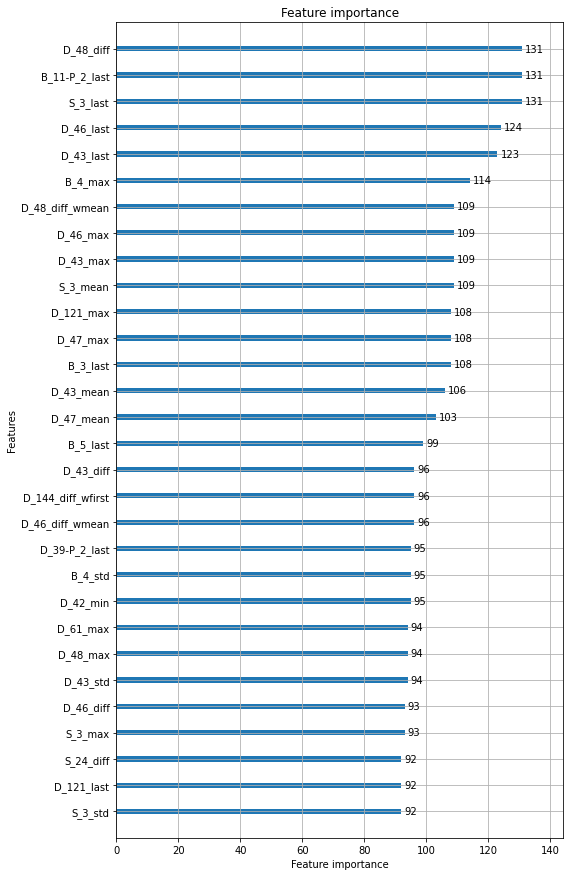

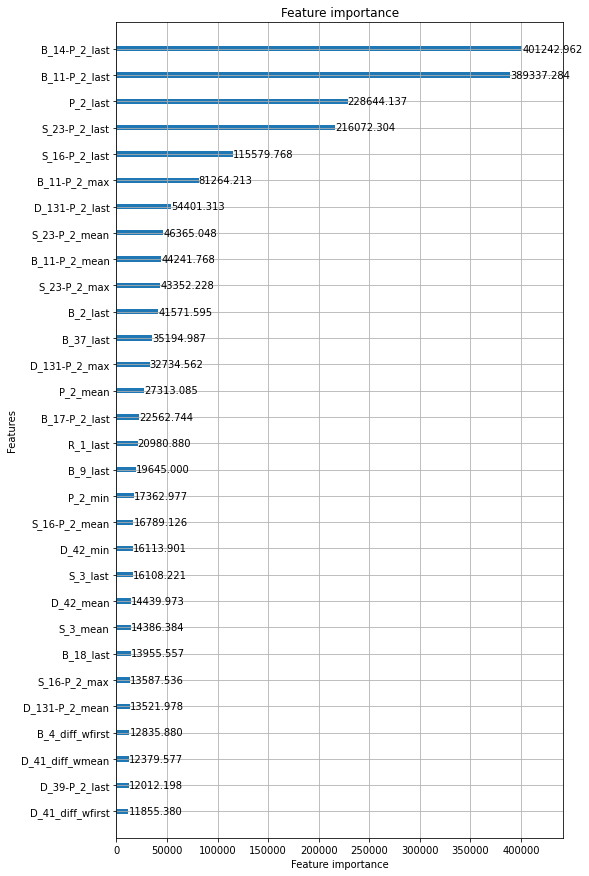

######################################## training model 4/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.764134	valid_0's recall_at4: 0.620198	valid_0's norm_gini: 0.90807


[100]	valid_0's amex_metric: 0.775233	valid_0's recall_at4: 0.635514	valid_0's norm_gini: 0.914952


[150]	valid_0's amex_metric: 0.783251	valid_0's recall_at4: 0.648012	valid_0's norm_gini: 0.918491


[200]	valid_0's amex_metric: 0.787508	valid_0's recall_at4: 0.65466	valid_0's norm_gini: 0.920357


[250]	valid_0's amex_metric: 0.789887	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.921496


[300]	valid_0's amex_metric: 0.790589	valid_0's recall_at4: 0.658952	valid_0's norm_gini: 0.922227


[350]	valid_0's amex_metric: 0.791466	valid_0's recall_at4: 0.660173	valid_0's norm_gini: 0.92276


[400]	valid_0's amex_metric: 0.792133	valid_0's recall_at4: 0.66114	valid_0's norm_gini: 0.923126


[450]	valid_0's amex_metric: 0.792119	valid_0's recall_at4: 0.660846	valid_0's norm_gini: 0.923392


[500]	valid_0's amex_metric: 0.7927	valid_0's recall_at4: 0.661772	valid_0's norm_gini: 0.923629


[550]	valid_0's amex_metric: 0.7934	valid_0's recall_at4: 0.663034	valid_0's norm_gini: 0.923767


[600]	valid_0's amex_metric: 0.793114	valid_0's recall_at4: 0.662319	valid_0's norm_gini: 0.92391


[650]	valid_0's amex_metric: 0.793808	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.923993


[700]	valid_0's amex_metric: 0.793651	valid_0's recall_at4: 0.663202	valid_0's norm_gini: 0.924099


[750]	valid_0's amex_metric: 0.793674	valid_0's recall_at4: 0.66316	valid_0's norm_gini: 0.924187


[800]	valid_0's amex_metric: 0.793799	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.92427


[850]	valid_0's amex_metric: 0.794029	valid_0's recall_at4: 0.663749	valid_0's norm_gini: 0.924308


[900]	valid_0's amex_metric: 0.794255	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.92434


[950]	valid_0's amex_metric: 0.79458	valid_0's recall_at4: 0.664801	valid_0's norm_gini: 0.924358


[1000]	valid_0's amex_metric: 0.79465	valid_0's recall_at4: 0.664927	valid_0's norm_gini: 0.924372


[1050]	valid_0's amex_metric: 0.794898	valid_0's recall_at4: 0.66539	valid_0's norm_gini: 0.924405


[1100]	valid_0's amex_metric: 0.794686	valid_0's recall_at4: 0.664927	valid_0's norm_gini: 0.924445


[1150]	valid_0's amex_metric: 0.794512	valid_0's recall_at4: 0.664591	valid_0's norm_gini: 0.924433


[1200]	valid_0's amex_metric: 0.794188	valid_0's recall_at4: 0.66396	valid_0's norm_gini: 0.924416


[1250]	valid_0's amex_metric: 0.794493	valid_0's recall_at4: 0.664549	valid_0's norm_gini: 0.924438


[1300]	valid_0's amex_metric: 0.794274	valid_0's recall_at4: 0.664128	valid_0's norm_gini: 0.92442


[1350]	valid_0's amex_metric: 0.794226	valid_0's recall_at4: 0.664002	valid_0's norm_gini: 0.924451


[1400]	valid_0's amex_metric: 0.794192	valid_0's recall_at4: 0.663918	valid_0's norm_gini: 0.924466


[1450]	valid_0's amex_metric: 0.794599	valid_0's recall_at4: 0.664717	valid_0's norm_gini: 0.924482


[1500]	valid_0's amex_metric: 0.794697	valid_0's recall_at4: 0.664885	valid_0's norm_gini: 0.924508


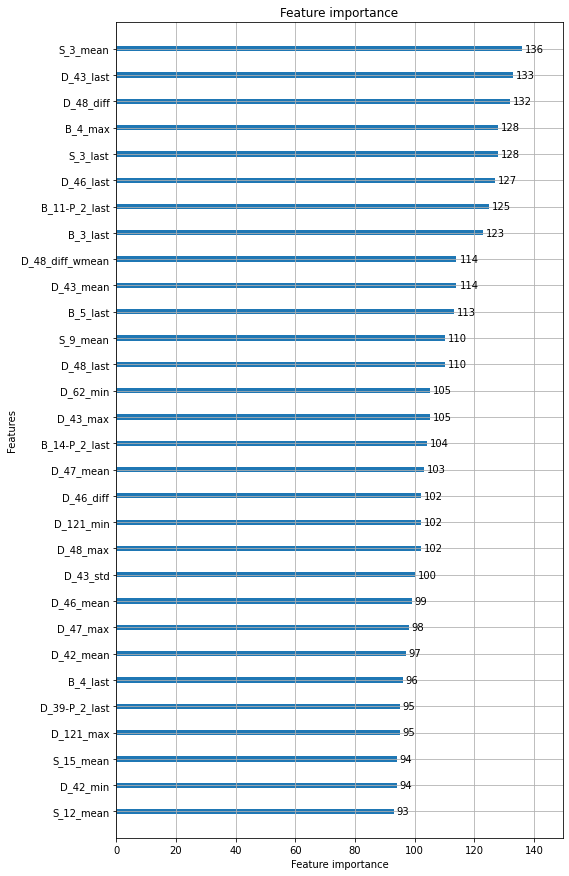

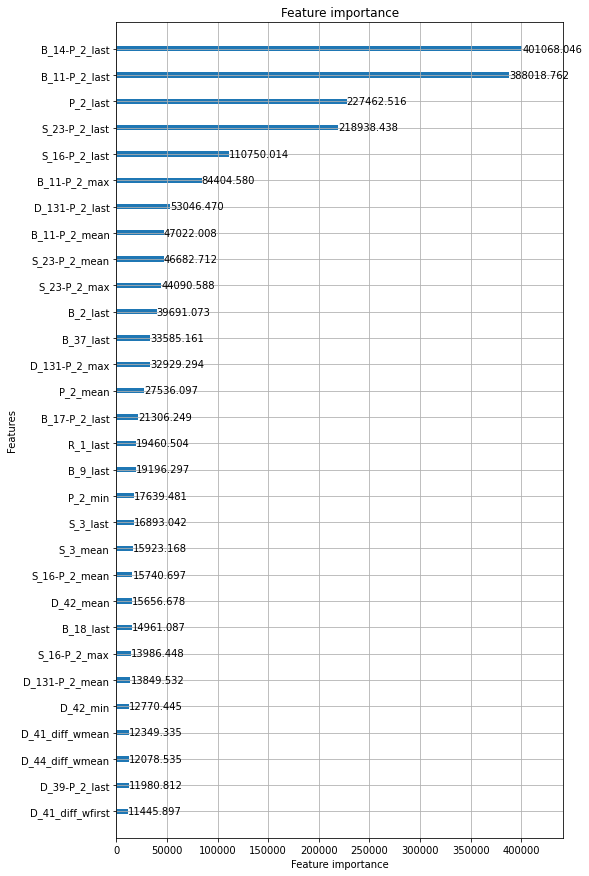

######################################## training model 5/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.762592	valid_0's recall_at4: 0.617926	valid_0's norm_gini: 0.907259


[100]	valid_0's amex_metric: 0.775496	valid_0's recall_at4: 0.636398	valid_0's norm_gini: 0.914593


[150]	valid_0's amex_metric: 0.781407	valid_0's recall_at4: 0.644603	valid_0's norm_gini: 0.918211


[200]	valid_0's amex_metric: 0.785038	valid_0's recall_at4: 0.649905	valid_0's norm_gini: 0.920171


[250]	valid_0's amex_metric: 0.787591	valid_0's recall_at4: 0.653861	valid_0's norm_gini: 0.921321


[300]	valid_0's amex_metric: 0.788379	valid_0's recall_at4: 0.654702	valid_0's norm_gini: 0.922056


[350]	valid_0's amex_metric: 0.789889	valid_0's recall_at4: 0.657227	valid_0's norm_gini: 0.922552


[400]	valid_0's amex_metric: 0.790502	valid_0's recall_at4: 0.658111	valid_0's norm_gini: 0.922894


[450]	valid_0's amex_metric: 0.791679	valid_0's recall_at4: 0.660215	valid_0's norm_gini: 0.923143


[500]	valid_0's amex_metric: 0.791979	valid_0's recall_at4: 0.660593	valid_0's norm_gini: 0.923364


[550]	valid_0's amex_metric: 0.791839	valid_0's recall_at4: 0.660173	valid_0's norm_gini: 0.923506


[600]	valid_0's amex_metric: 0.79164	valid_0's recall_at4: 0.659668	valid_0's norm_gini: 0.923613


[650]	valid_0's amex_metric: 0.791311	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.923711


[700]	valid_0's amex_metric: 0.791235	valid_0's recall_at4: 0.6587	valid_0's norm_gini: 0.92377


[750]	valid_0's amex_metric: 0.791414	valid_0's recall_at4: 0.659036	valid_0's norm_gini: 0.923792


[800]	valid_0's amex_metric: 0.79137	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.92383


[850]	valid_0's amex_metric: 0.791531	valid_0's recall_at4: 0.659205	valid_0's norm_gini: 0.923857


[900]	valid_0's amex_metric: 0.792284	valid_0's recall_at4: 0.660677	valid_0's norm_gini: 0.92389


[950]	valid_0's amex_metric: 0.791819	valid_0's recall_at4: 0.65971	valid_0's norm_gini: 0.923928


[1000]	valid_0's amex_metric: 0.791467	valid_0's recall_at4: 0.658994	valid_0's norm_gini: 0.923939


[1050]	valid_0's amex_metric: 0.791388	valid_0's recall_at4: 0.658826	valid_0's norm_gini: 0.923949


[1100]	valid_0's amex_metric: 0.791191	valid_0's recall_at4: 0.658447	valid_0's norm_gini: 0.923934


[1150]	valid_0's amex_metric: 0.790764	valid_0's recall_at4: 0.657564	valid_0's norm_gini: 0.923964


[1200]	valid_0's amex_metric: 0.790578	valid_0's recall_at4: 0.657185	valid_0's norm_gini: 0.923971


[1250]	valid_0's amex_metric: 0.790675	valid_0's recall_at4: 0.657395	valid_0's norm_gini: 0.923955


[1300]	valid_0's amex_metric: 0.791431	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.923953


[1350]	valid_0's amex_metric: 0.791446	valid_0's recall_at4: 0.658952	valid_0's norm_gini: 0.923939


[1400]	valid_0's amex_metric: 0.791629	valid_0's recall_at4: 0.659331	valid_0's norm_gini: 0.923927


[1450]	valid_0's amex_metric: 0.791824	valid_0's recall_at4: 0.65971	valid_0's norm_gini: 0.923939


[1500]	valid_0's amex_metric: 0.791585	valid_0's recall_at4: 0.659247	valid_0's norm_gini: 0.923923


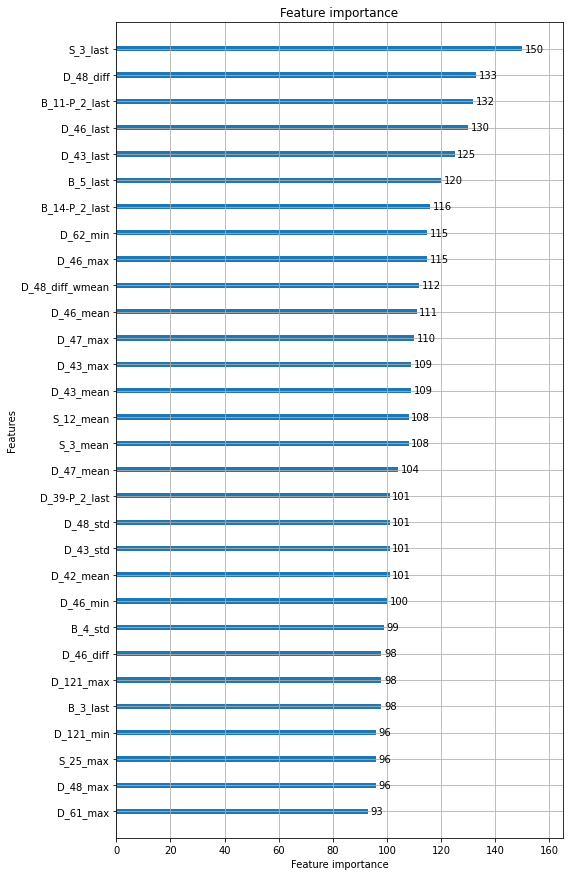

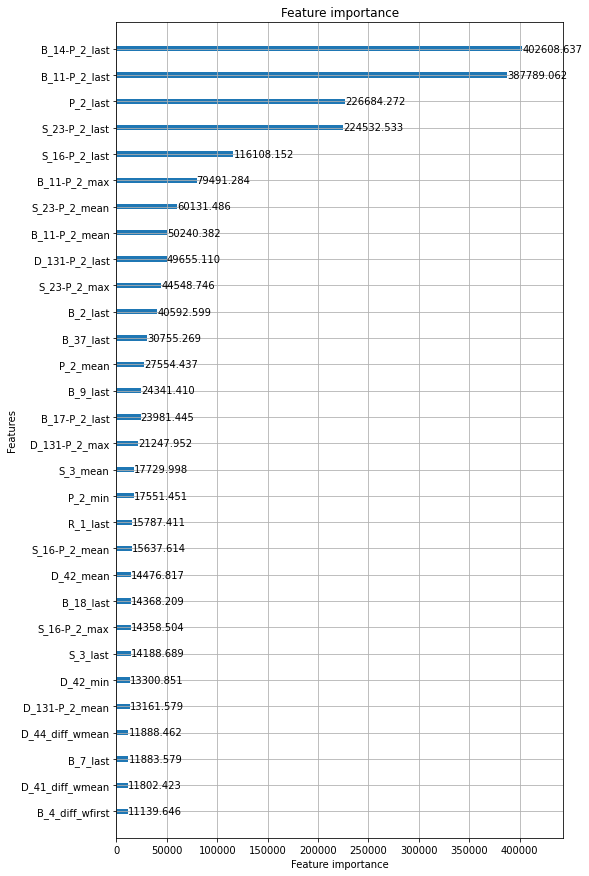

Training time: 27.4363183816274 min.
OOF recall_at4: 0.6646160837513044
OOF normalized_gini: 0.9243106426636991
OOF competition metric: 0.7944633632075018


############################### repeated cross-validation step: 5/5 ################################


######################################## training model 1/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.764567	valid_0's recall_at4: 0.620887	valid_0's norm_gini: 0.908247


[100]	valid_0's amex_metric: 0.777954	valid_0's recall_at4: 0.640663	valid_0's norm_gini: 0.915245


[150]	valid_0's amex_metric: 0.784284	valid_0's recall_at4: 0.649626	valid_0's norm_gini: 0.918943


[200]	valid_0's amex_metric: 0.788356	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.920985


[250]	valid_0's amex_metric: 0.79213	valid_0's recall_at4: 0.662122	valid_0's norm_gini: 0.922138


[300]	valid_0's amex_metric: 0.793856	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.922897


[350]	valid_0's amex_metric: 0.794452	valid_0's recall_at4: 0.665489	valid_0's norm_gini: 0.923415


[400]	valid_0's amex_metric: 0.795397	valid_0's recall_at4: 0.667003	valid_0's norm_gini: 0.923792


[450]	valid_0's amex_metric: 0.795613	valid_0's recall_at4: 0.66713	valid_0's norm_gini: 0.924097


[500]	valid_0's amex_metric: 0.796158	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.924303


[550]	valid_0's amex_metric: 0.796702	valid_0's recall_at4: 0.668939	valid_0's norm_gini: 0.924465


[600]	valid_0's amex_metric: 0.796885	valid_0's recall_at4: 0.669149	valid_0's norm_gini: 0.92462


[650]	valid_0's amex_metric: 0.797406	valid_0's recall_at4: 0.670075	valid_0's norm_gini: 0.924736


[700]	valid_0's amex_metric: 0.797326	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.92483


[750]	valid_0's amex_metric: 0.797089	valid_0's recall_at4: 0.669275	valid_0's norm_gini: 0.924903


[800]	valid_0's amex_metric: 0.797641	valid_0's recall_at4: 0.670327	valid_0's norm_gini: 0.924955


[850]	valid_0's amex_metric: 0.79771	valid_0's recall_at4: 0.670454	valid_0's norm_gini: 0.924966


[900]	valid_0's amex_metric: 0.798288	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.925028


[950]	valid_0's amex_metric: 0.798425	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.925051


[1000]	valid_0's amex_metric: 0.798418	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.925077


[1050]	valid_0's amex_metric: 0.798674	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.925127


[1100]	valid_0's amex_metric: 0.798135	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.925143


[1150]	valid_0's amex_metric: 0.798327	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.925148


[1200]	valid_0's amex_metric: 0.798107	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.92513


[1250]	valid_0's amex_metric: 0.798575	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.925097


[1300]	valid_0's amex_metric: 0.79832	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.925135


[1350]	valid_0's amex_metric: 0.797882	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.9251


[1400]	valid_0's amex_metric: 0.798186	valid_0's recall_at4: 0.671253	valid_0's norm_gini: 0.925119


[1450]	valid_0's amex_metric: 0.797657	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.925113


[1500]	valid_0's amex_metric: 0.797773	valid_0's recall_at4: 0.670454	valid_0's norm_gini: 0.925092


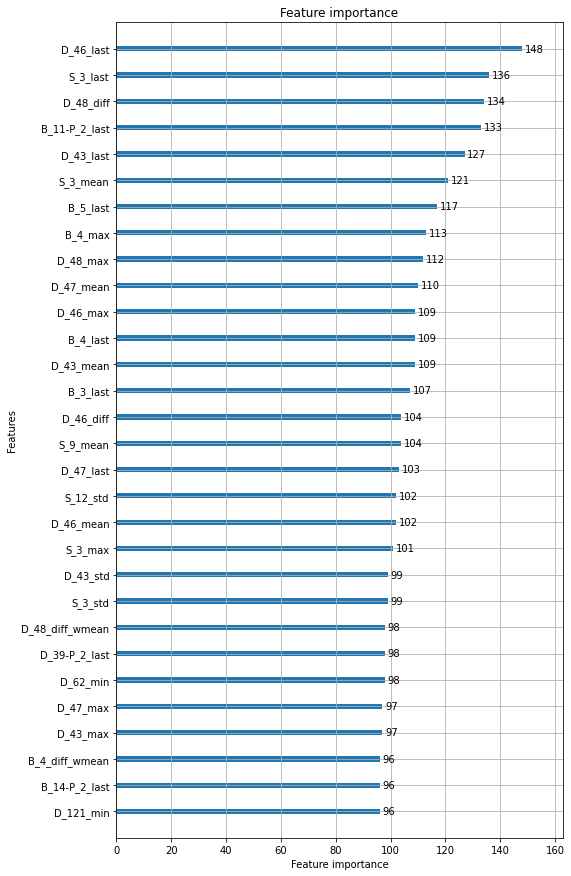

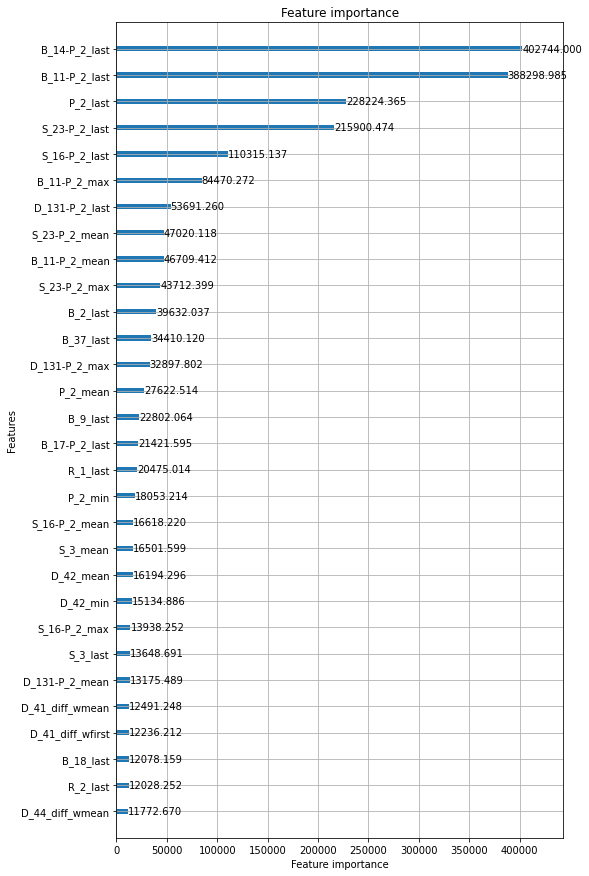

######################################## training model 2/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.768381	valid_0's recall_at4: 0.626862	valid_0's norm_gini: 0.9099


[100]	valid_0's amex_metric: 0.781891	valid_0's recall_at4: 0.64668	valid_0's norm_gini: 0.917103


[150]	valid_0's amex_metric: 0.788106	valid_0's recall_at4: 0.65539	valid_0's norm_gini: 0.920822


[200]	valid_0's amex_metric: 0.79132	valid_0's recall_at4: 0.659892	valid_0's norm_gini: 0.922747


[250]	valid_0's amex_metric: 0.793044	valid_0's recall_at4: 0.662164	valid_0's norm_gini: 0.923924


[300]	valid_0's amex_metric: 0.795569	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.924682


[350]	valid_0's amex_metric: 0.796232	valid_0's recall_at4: 0.667256	valid_0's norm_gini: 0.925208


[400]	valid_0's amex_metric: 0.796382	valid_0's recall_at4: 0.667214	valid_0's norm_gini: 0.92555


[450]	valid_0's amex_metric: 0.797324	valid_0's recall_at4: 0.668855	valid_0's norm_gini: 0.925794


[500]	valid_0's amex_metric: 0.797939	valid_0's recall_at4: 0.669907	valid_0's norm_gini: 0.925971


[550]	valid_0's amex_metric: 0.797894	valid_0's recall_at4: 0.669696	valid_0's norm_gini: 0.926091


[600]	valid_0's amex_metric: 0.798115	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.926198


[650]	valid_0's amex_metric: 0.798221	valid_0's recall_at4: 0.670117	valid_0's norm_gini: 0.926326


[700]	valid_0's amex_metric: 0.799166	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.926406


[750]	valid_0's amex_metric: 0.79902	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.926493


[800]	valid_0's amex_metric: 0.798601	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.926538


[850]	valid_0's amex_metric: 0.798664	valid_0's recall_at4: 0.67079	valid_0's norm_gini: 0.926539


[900]	valid_0's amex_metric: 0.798613	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.926562


[950]	valid_0's amex_metric: 0.798785	valid_0's recall_at4: 0.670959	valid_0's norm_gini: 0.926612


[1000]	valid_0's amex_metric: 0.799504	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.926662


[1050]	valid_0's amex_metric: 0.800028	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926657


[1100]	valid_0's amex_metric: 0.798691	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.926676


[1150]	valid_0's amex_metric: 0.79952	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.926693


[1200]	valid_0's amex_metric: 0.799617	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.926718


[1250]	valid_0's amex_metric: 0.799015	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.926693


[1300]	valid_0's amex_metric: 0.799022	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.926707


[1350]	valid_0's amex_metric: 0.799274	valid_0's recall_at4: 0.671842	valid_0's norm_gini: 0.926705


[1400]	valid_0's amex_metric: 0.79899	valid_0's recall_at4: 0.671295	valid_0's norm_gini: 0.926685


[1450]	valid_0's amex_metric: 0.799205	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.926652


[1500]	valid_0's amex_metric: 0.799183	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.926607


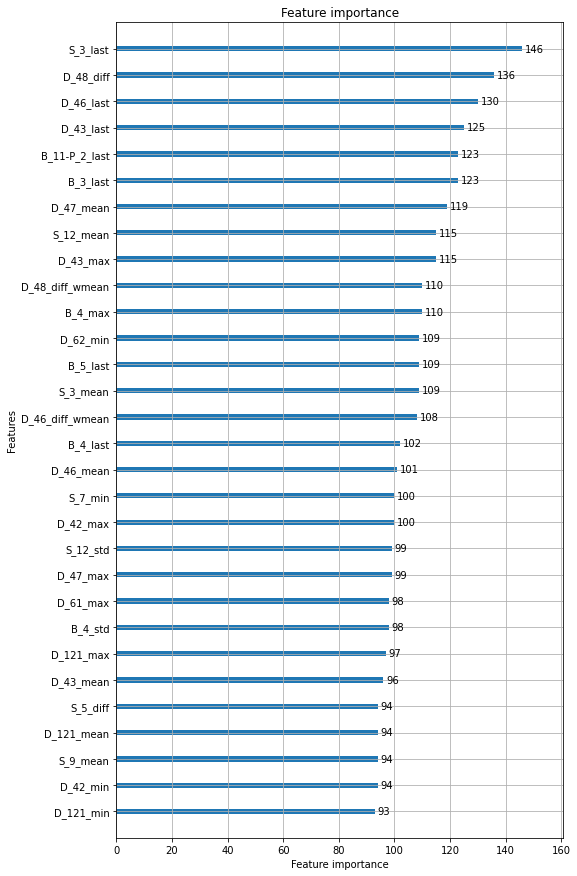

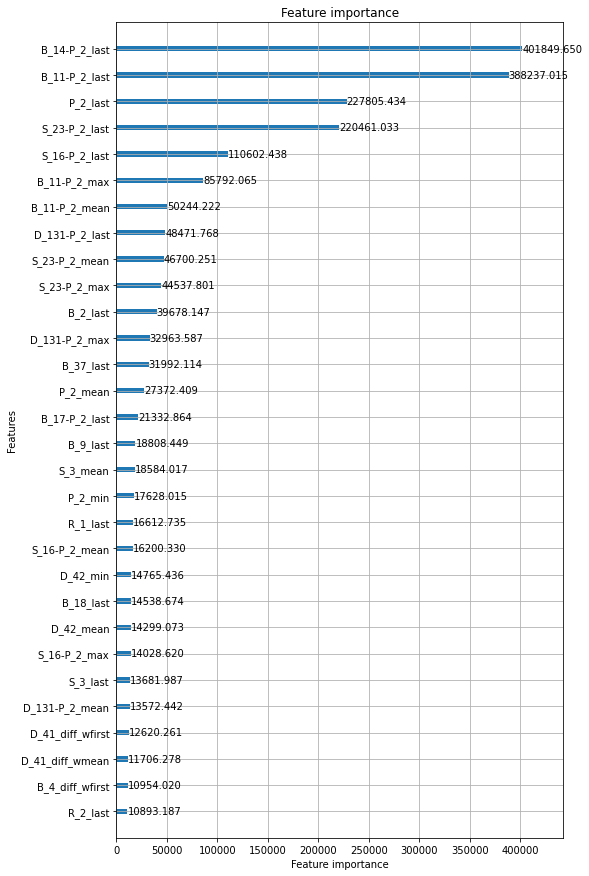

######################################## training model 3/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.763781	valid_0's recall_at4: 0.619541	valid_0's norm_gini: 0.908021


[100]	valid_0's amex_metric: 0.775826	valid_0's recall_at4: 0.636666	valid_0's norm_gini: 0.914987


[150]	valid_0's amex_metric: 0.781951	valid_0's recall_at4: 0.645292	valid_0's norm_gini: 0.918611


[200]	valid_0's amex_metric: 0.785171	valid_0's recall_at4: 0.64992	valid_0's norm_gini: 0.920422


[250]	valid_0's amex_metric: 0.78748	valid_0's recall_at4: 0.653412	valid_0's norm_gini: 0.921547


[300]	valid_0's amex_metric: 0.788578	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.922271


[350]	valid_0's amex_metric: 0.789285	valid_0's recall_at4: 0.655811	valid_0's norm_gini: 0.922759


[400]	valid_0's amex_metric: 0.790546	valid_0's recall_at4: 0.657999	valid_0's norm_gini: 0.923093


[450]	valid_0's amex_metric: 0.790797	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.923342


[500]	valid_0's amex_metric: 0.791797	valid_0's recall_at4: 0.660061	valid_0's norm_gini: 0.923534


[550]	valid_0's amex_metric: 0.792435	valid_0's recall_at4: 0.661155	valid_0's norm_gini: 0.923715


[600]	valid_0's amex_metric: 0.792526	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.923813


[650]	valid_0's amex_metric: 0.792568	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.923898


[700]	valid_0's amex_metric: 0.79286	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.923977


[750]	valid_0's amex_metric: 0.793325	valid_0's recall_at4: 0.662585	valid_0's norm_gini: 0.924065


[800]	valid_0's amex_metric: 0.793782	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.924095


[850]	valid_0's amex_metric: 0.794043	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.924154


[900]	valid_0's amex_metric: 0.794231	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.924193


[950]	valid_0's amex_metric: 0.794508	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.924243


[1000]	valid_0's amex_metric: 0.794526	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.924279


[1050]	valid_0's amex_metric: 0.794202	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.924261


[1100]	valid_0's amex_metric: 0.794115	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.924298


[1150]	valid_0's amex_metric: 0.794108	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.924284


[1200]	valid_0's amex_metric: 0.793677	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.924306


[1250]	valid_0's amex_metric: 0.793426	valid_0's recall_at4: 0.662543	valid_0's norm_gini: 0.924309


[1300]	valid_0's amex_metric: 0.794122	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.924313


[1350]	valid_0's amex_metric: 0.793463	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.924299


[1400]	valid_0's amex_metric: 0.793956	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.924274


[1450]	valid_0's amex_metric: 0.793403	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.924305


[1500]	valid_0's amex_metric: 0.793781	valid_0's recall_at4: 0.663258	valid_0's norm_gini: 0.924304


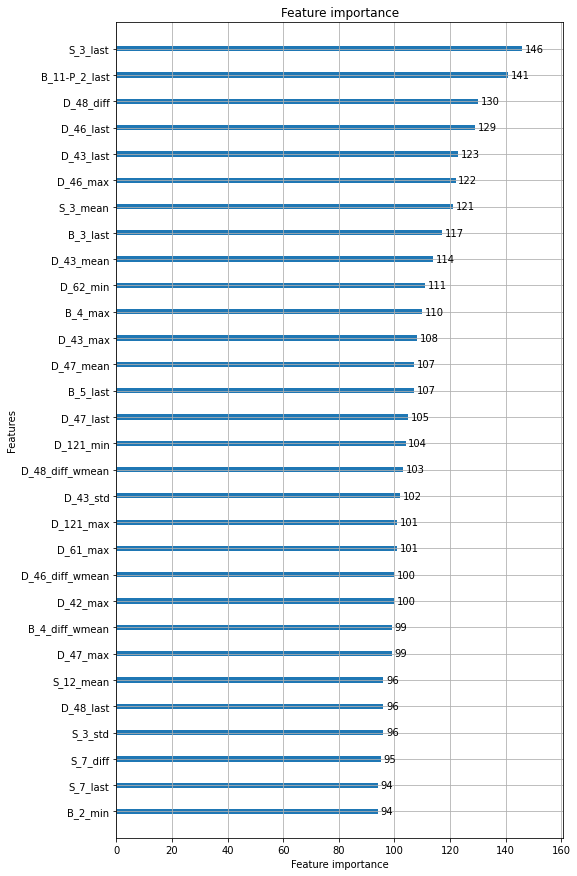

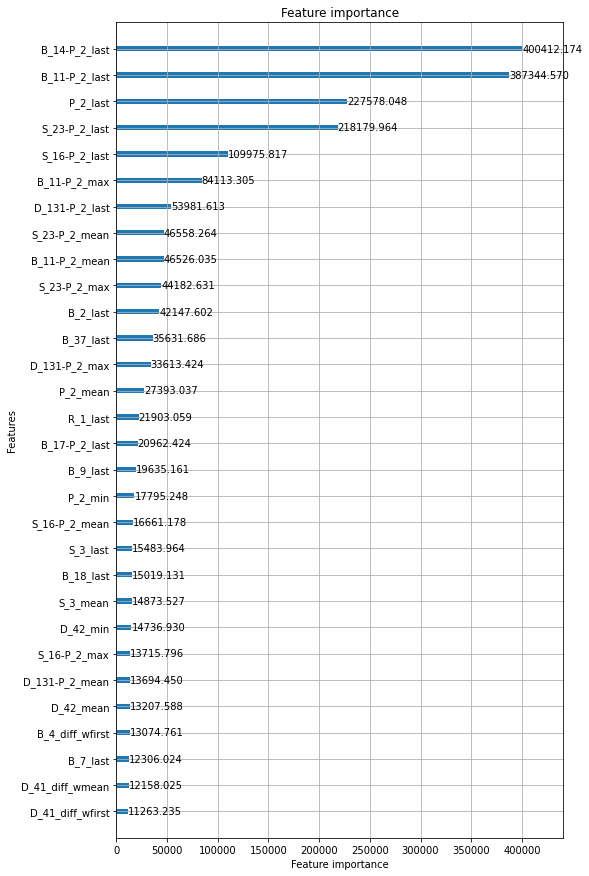

######################################## training model 4/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.762691	valid_0's recall_at4: 0.617547	valid_0's norm_gini: 0.907835


[100]	valid_0's amex_metric: 0.775373	valid_0's recall_at4: 0.635893	valid_0's norm_gini: 0.914852


[150]	valid_0's amex_metric: 0.782612	valid_0's recall_at4: 0.646792	valid_0's norm_gini: 0.918433


[200]	valid_0's amex_metric: 0.7851	valid_0's recall_at4: 0.649779	valid_0's norm_gini: 0.92042


[250]	valid_0's amex_metric: 0.788365	valid_0's recall_at4: 0.655081	valid_0's norm_gini: 0.921649


[300]	valid_0's amex_metric: 0.789416	valid_0's recall_at4: 0.656428	valid_0's norm_gini: 0.922404


[350]	valid_0's amex_metric: 0.790375	valid_0's recall_at4: 0.6579	valid_0's norm_gini: 0.92285


[400]	valid_0's amex_metric: 0.791139	valid_0's recall_at4: 0.659078	valid_0's norm_gini: 0.923199


[450]	valid_0's amex_metric: 0.791279	valid_0's recall_at4: 0.659078	valid_0's norm_gini: 0.92348


[500]	valid_0's amex_metric: 0.791709	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.923666


[550]	valid_0's amex_metric: 0.791812	valid_0's recall_at4: 0.659836	valid_0's norm_gini: 0.923789


[600]	valid_0's amex_metric: 0.792159	valid_0's recall_at4: 0.660425	valid_0's norm_gini: 0.923893


[650]	valid_0's amex_metric: 0.79171	valid_0's recall_at4: 0.659415	valid_0's norm_gini: 0.924006


[700]	valid_0's amex_metric: 0.792208	valid_0's recall_at4: 0.660257	valid_0's norm_gini: 0.924159


[750]	valid_0's amex_metric: 0.792034	valid_0's recall_at4: 0.659836	valid_0's norm_gini: 0.924233


[800]	valid_0's amex_metric: 0.791965	valid_0's recall_at4: 0.659625	valid_0's norm_gini: 0.924305


[850]	valid_0's amex_metric: 0.792889	valid_0's recall_at4: 0.661435	valid_0's norm_gini: 0.924343


[900]	valid_0's amex_metric: 0.792694	valid_0's recall_at4: 0.661014	valid_0's norm_gini: 0.924373


[950]	valid_0's amex_metric: 0.792754	valid_0's recall_at4: 0.66114	valid_0's norm_gini: 0.924368


[1000]	valid_0's amex_metric: 0.793012	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.924378


[1050]	valid_0's amex_metric: 0.792524	valid_0's recall_at4: 0.660593	valid_0's norm_gini: 0.924454


[1100]	valid_0's amex_metric: 0.793122	valid_0's recall_at4: 0.661772	valid_0's norm_gini: 0.924472


[1150]	valid_0's amex_metric: 0.793812	valid_0's recall_at4: 0.663118	valid_0's norm_gini: 0.924506


[1200]	valid_0's amex_metric: 0.793062	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.924479


[1250]	valid_0's amex_metric: 0.793656	valid_0's recall_at4: 0.662866	valid_0's norm_gini: 0.924446


[1300]	valid_0's amex_metric: 0.79372	valid_0's recall_at4: 0.662992	valid_0's norm_gini: 0.924447


[1350]	valid_0's amex_metric: 0.793964	valid_0's recall_at4: 0.663497	valid_0's norm_gini: 0.924431


[1400]	valid_0's amex_metric: 0.794309	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.924449


[1450]	valid_0's amex_metric: 0.792937	valid_0's recall_at4: 0.661435	valid_0's norm_gini: 0.92444


[1500]	valid_0's amex_metric: 0.794303	valid_0's recall_at4: 0.664212	valid_0's norm_gini: 0.924395


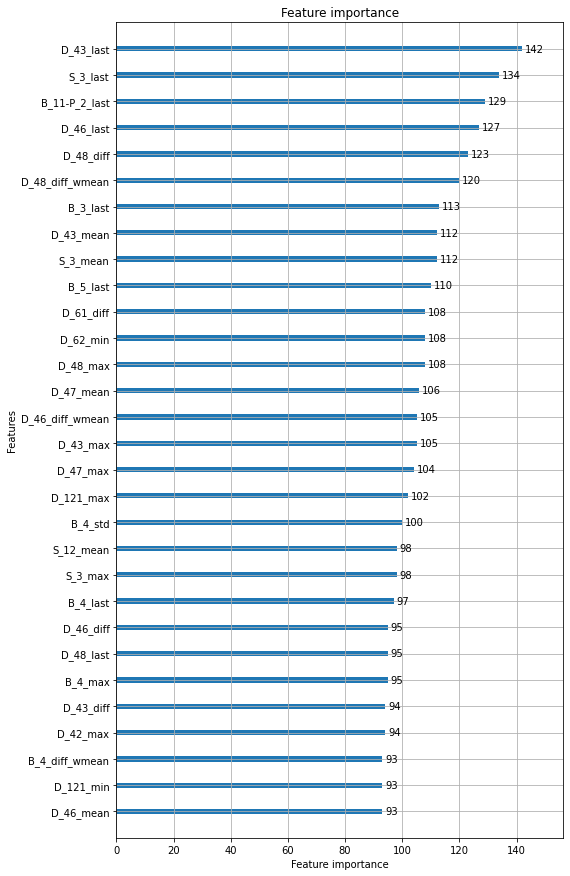

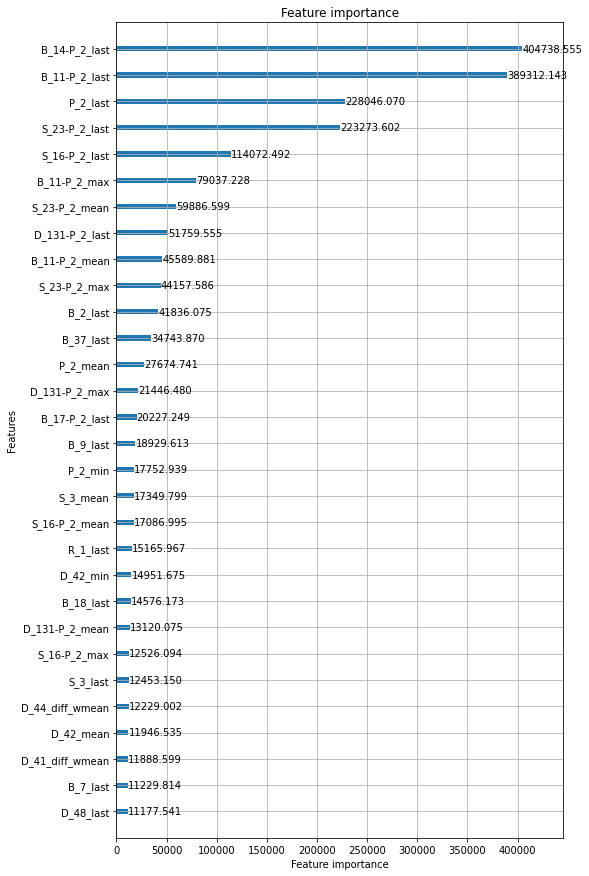

######################################## training model 5/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.761677	valid_0's recall_at4: 0.616874	valid_0's norm_gini: 0.906481


[100]	valid_0's amex_metric: 0.77306	valid_0's recall_at4: 0.632527	valid_0's norm_gini: 0.913594


[150]	valid_0's amex_metric: 0.780571	valid_0's recall_at4: 0.643762	valid_0's norm_gini: 0.917381


[200]	valid_0's amex_metric: 0.782922	valid_0's recall_at4: 0.646497	valid_0's norm_gini: 0.919347


[250]	valid_0's amex_metric: 0.785413	valid_0's recall_at4: 0.650326	valid_0's norm_gini: 0.9205


[300]	valid_0's amex_metric: 0.786626	valid_0's recall_at4: 0.651967	valid_0's norm_gini: 0.921286


[350]	valid_0's amex_metric: 0.787617	valid_0's recall_at4: 0.653356	valid_0's norm_gini: 0.921878


[400]	valid_0's amex_metric: 0.788366	valid_0's recall_at4: 0.654492	valid_0's norm_gini: 0.92224


[450]	valid_0's amex_metric: 0.789704	valid_0's recall_at4: 0.656848	valid_0's norm_gini: 0.92256


[500]	valid_0's amex_metric: 0.790697	valid_0's recall_at4: 0.658574	valid_0's norm_gini: 0.922821


[550]	valid_0's amex_metric: 0.790634	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.922988


[600]	valid_0's amex_metric: 0.790631	valid_0's recall_at4: 0.658153	valid_0's norm_gini: 0.923109


[650]	valid_0's amex_metric: 0.790671	valid_0's recall_at4: 0.658111	valid_0's norm_gini: 0.923232


[700]	valid_0's amex_metric: 0.79119	valid_0's recall_at4: 0.659078	valid_0's norm_gini: 0.923301


[750]	valid_0's amex_metric: 0.791197	valid_0's recall_at4: 0.658994	valid_0's norm_gini: 0.923399


[800]	valid_0's amex_metric: 0.791193	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.923476


[850]	valid_0's amex_metric: 0.790415	valid_0's recall_at4: 0.657311	valid_0's norm_gini: 0.923519


[900]	valid_0's amex_metric: 0.789846	valid_0's recall_at4: 0.656091	valid_0's norm_gini: 0.923601


[950]	valid_0's amex_metric: 0.790249	valid_0's recall_at4: 0.656848	valid_0's norm_gini: 0.923651


[1000]	valid_0's amex_metric: 0.790361	valid_0's recall_at4: 0.657059	valid_0's norm_gini: 0.923663


[1050]	valid_0's amex_metric: 0.790069	valid_0's recall_at4: 0.656428	valid_0's norm_gini: 0.92371


[1100]	valid_0's amex_metric: 0.790886	valid_0's recall_at4: 0.658069	valid_0's norm_gini: 0.923703


[1150]	valid_0's amex_metric: 0.790599	valid_0's recall_at4: 0.657479	valid_0's norm_gini: 0.923718


[1200]	valid_0's amex_metric: 0.790871	valid_0's recall_at4: 0.657984	valid_0's norm_gini: 0.923758


[1250]	valid_0's amex_metric: 0.791362	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.923815


[1300]	valid_0's amex_metric: 0.790986	valid_0's recall_at4: 0.658153	valid_0's norm_gini: 0.923819


[1350]	valid_0's amex_metric: 0.790872	valid_0's recall_at4: 0.6579	valid_0's norm_gini: 0.923843


[1400]	valid_0's amex_metric: 0.790532	valid_0's recall_at4: 0.657227	valid_0's norm_gini: 0.923838


[1450]	valid_0's amex_metric: 0.790444	valid_0's recall_at4: 0.657017	valid_0's norm_gini: 0.923871


[1500]	valid_0's amex_metric: 0.790032	valid_0's recall_at4: 0.656217	valid_0's norm_gini: 0.923847


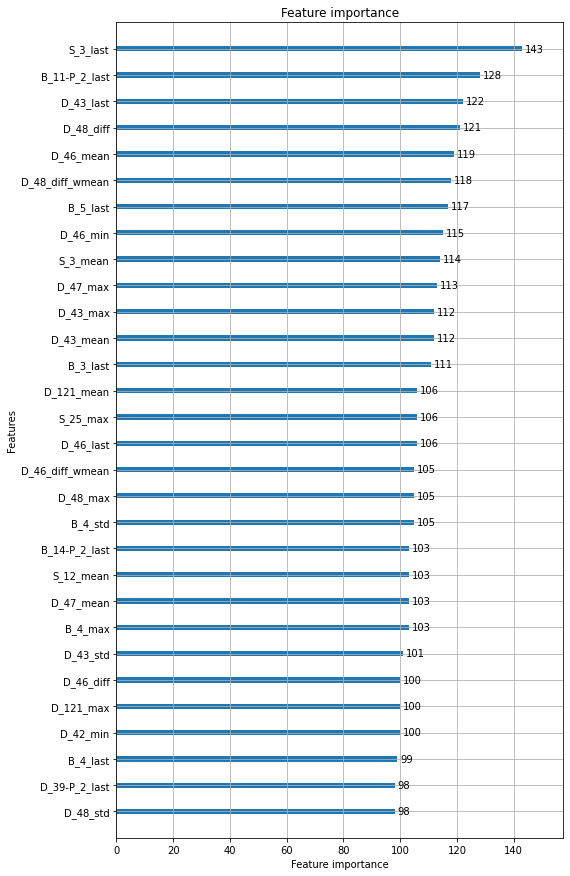

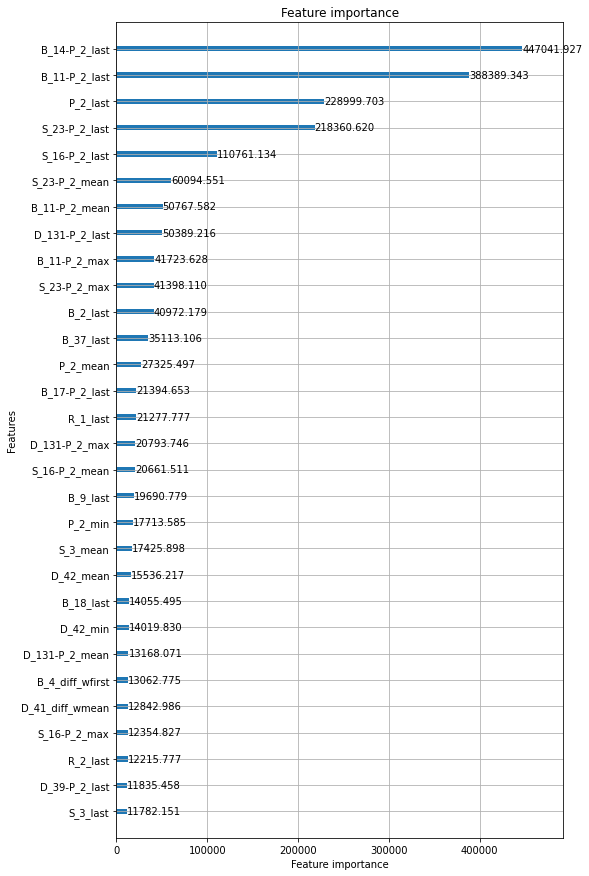

Training time: 27.397441319624583 min.
OOF recall_at4: 0.6649527047497222
OOF normalized_gini: 0.9243837798476745
OOF competition metric: 0.7946682422986984


CPU times: user 15h 47min 58s, sys: 2min 23s, total: 15h 50min 21s
Wall time: 2h 36min 27s


In [11]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))
    
    if "fold" in train.columns:
        train.drop("fold", axis=1, inplace=True)
    folds = pd.read_parquet(f'../data/processed/cv{repetition}.parquet')
    train = pd.merge(train, folds, how="inner", on="customer_ID")
    
    tic = time.time()
    models,oof = train_models(train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
          
    all_models.extend(models)
    all_oof_dfs.append(oof)
          
    del folds; gc.collect()

In [12]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

,recall_at4,gini,metric
0,0.663833,0.924408,0.794121
1,0.664667,0.924479,0.794573
2,0.664044,0.924589,0.794316
3,0.664616,0.924311,0.794463
4,0.664953,0.924384,0.794668



mean:


recall_at4    0.664423
gini          0.924434
metric        0.794428
dtype: float64


std:


recall_at4    0.000466
gini          0.000105
metric        0.000216
dtype: float64

In [13]:
del train
gc.collect()

21

***
## make predictions and submit

In [14]:
def make_predictions(dataframe:pd.DataFrame, input_feats:list, models:list) -> np.array:
    preds = [model.predict(dataframe[input_feats]) for model in models]
    return np.mean(preds, axis=0)    

In [15]:
test = pd.read_parquet("../data/processed/dsv02/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [16]:
%%time

save_pl = False
path_pl = "../data/subs/lgbm-bce-dsv02-pl/pl/iter0"
all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    imin = repetition*5
    imax = (repetition+1)*5
    
    preds = list()
    for fold,idx in enumerate(range(imin, imax)):
        pred = all_models[idx].predict(test[input_feats])
        if save_pl:
            test["prediction"] = pred
            test[["prediction"]].to_parquet(f"{path_pl}/cv{repetition}/pl-fold{fold}.parquet")
        preds.append(pred)
    all_preds.extend(preds)
       
    test["prediction"] = np.mean(preds, axis=0)
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(f"../data/subs/lgbm-bce-dsv02/submission-cv{repetition}.csv", index=False)

CPU times: user 1h 54min 31s, sys: 1min 36s, total: 1h 56min 7s
Wall time: 18min 37s


In [17]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(f"../data/subs/lgbm-bce-dsv02/submission-all.csv", index=False)

CPU times: user 3.74 s, sys: 954 ms, total: 4.69 s
Wall time: 4.99 s


***